# Regression Analysis runs SAS in Jupyter Notebooks with SASpy

###     Short dataset Summary:
        Lists estimates of the percentage of body fat determined by underwater
        weighing and various body circumference measurements for 252 men.

    https://lib.stat.cmu.edu/datasets/bodyfat
    
    Content
    The variables listed below, from left to right, are:

        Density determined from underwater weighing
        Percent body fat from Siri's (1956) equation
        Age (years)
        Weight (lbs)
        Height (inches)
        Neck circumference (cm)
        Chest circumference (cm)
        Abdomen 2 circumference (cm)
        Hip circumference (cm)
        Thigh circumference (cm)
        Knee circumference (cm)
        Ankle circumference (cm)
        Biceps (extended) circumference (cm)
        Forearm circumference (cm)
        Wrist circumference (cm)

#### Formula:

$bodyfatBrozek = \large\frac{457}{density} - 414.2$
  
$bodyfatSiri = \large\frac{495}{density} - 450$

$FatFreeWeight = \large(1 - \frac{brozek}{100}) \times weight\_lbs$

$BMI = \large(\frac{weight\_lbs}{[height\_in]^2} ) \times 703$

In [1]:
import sys
try:
    import saspy
except:
    !pip install saspy

In [2]:
# check the version of SASPy
saspy.__version__

'5.4.4'

In [3]:
import pandas as pd
import seaborn as sns

### Submit the SASsession object to get info about your session

In [4]:
# Start a SAS session, SAS is running in UTF-8

sas_sess = saspy.SASsession()
#sas_sess

Using SAS Config named: oda
SAS Connection established. Subprocess id is 3432



In [5]:
%%SAS sas_sess
/* check datasets on SAS OnDemand my home library*/
ods select Members; /* ods output Members=Members;*/

proc datasets library=home memtype=data;
run;

In [6]:
%%SAS sas_sess

ods select Variables;
proc contents data="/home/u61624884/bodyfat.sas7bdat"; 
run;
ods select default;

DATA tmp_bodyfat;
    set '/home/u61624884/bodyfat.sas7bdat';
RUN;

/* calculate quartile values for age, Density and Bodyfat */
PROC means DATA=tmp_bodyfat min q1 q3 max;
    var Density bodyfat age;
RUN;



## EXPLORING DATA

#### Create new categorical variable for outcome variable bodyfat (fat_value_cat), and independent variable Density (Density_cat) and age (age_cat), divided them into 3 levels “Low”(min~1st qu), “Medium”(1st qu ~ 3rd qu), “High”(3rd qu ~ max)


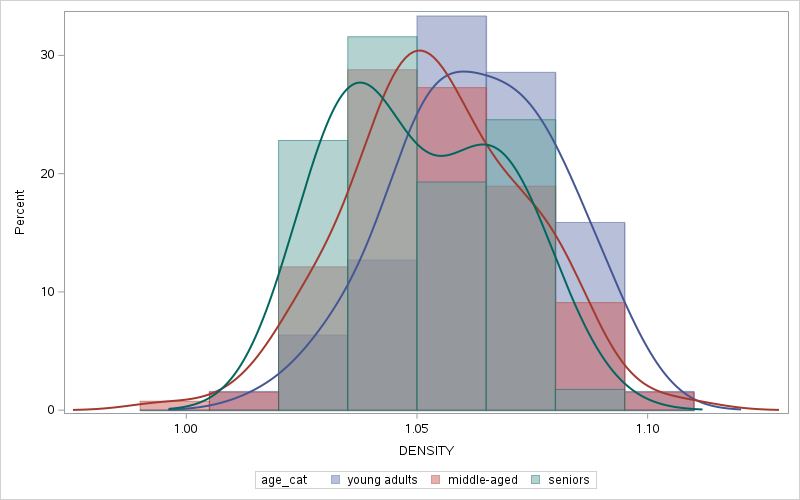
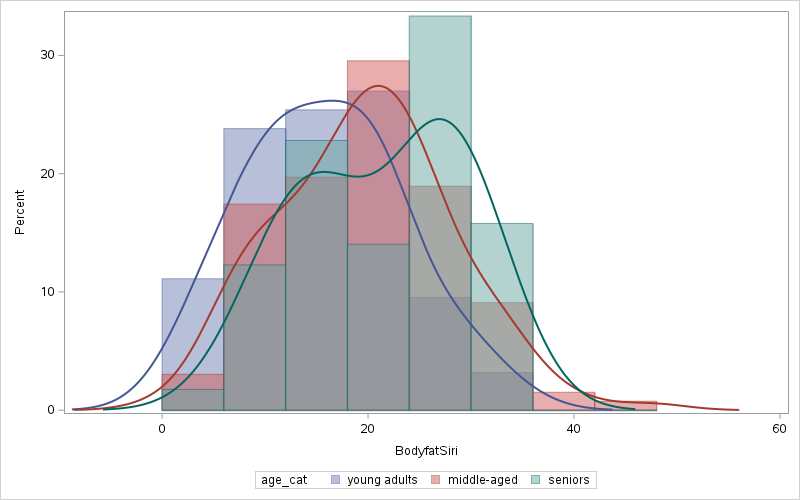
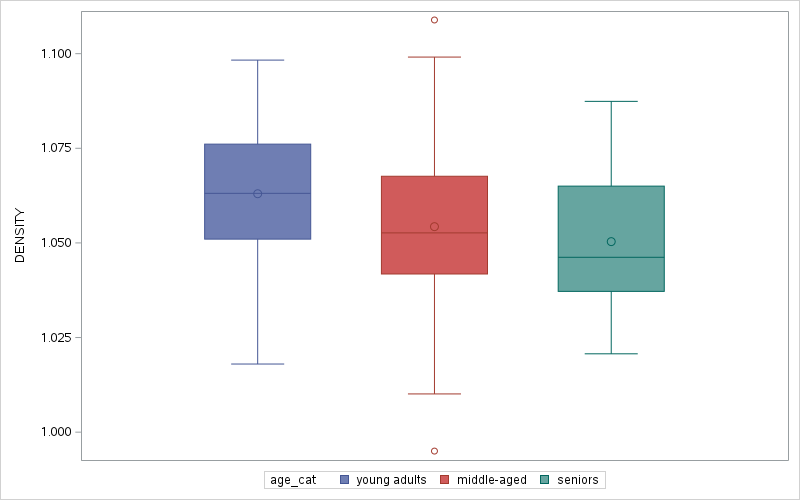
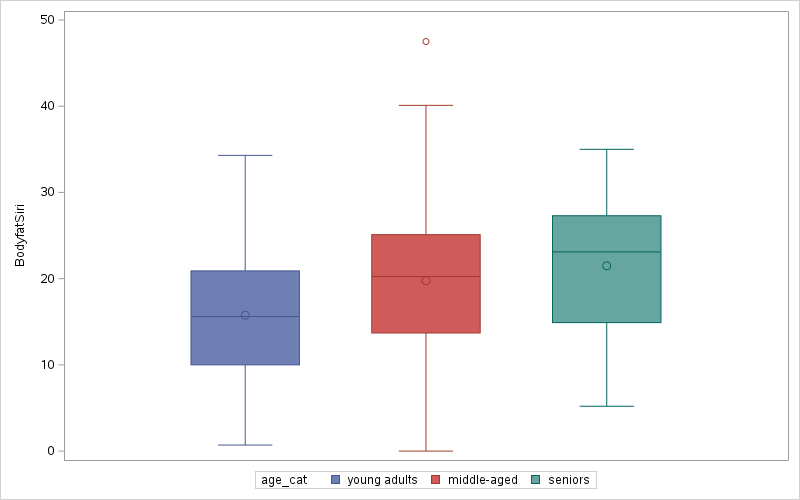
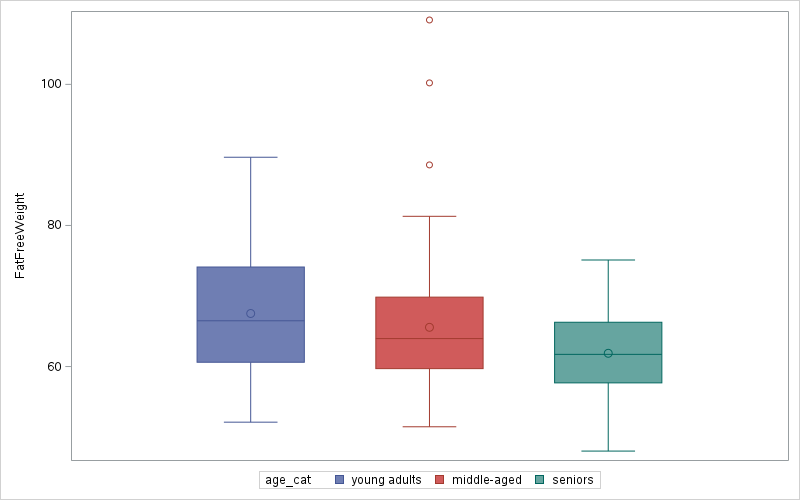
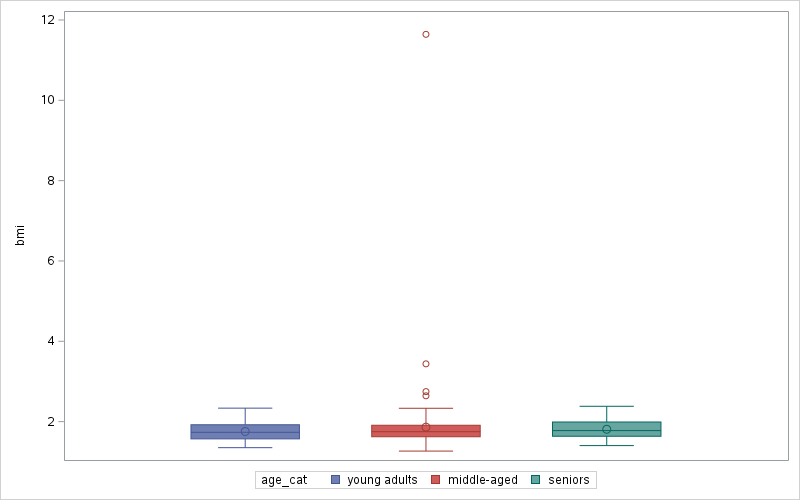

In [6]:
%%SAS sas_sess

data my_bodyfat;
    set '/home/u61624884/bodyfat.sas7bdat' (rename=(Bodyfat=BodyfatSiri)); /* rename bodyfat to bodyfatSiri */
    format bmi BEST12. heightInMeters BEST12. weightInKG BEST12. BodyfatBrozek BEST12. FatFreeWeight BEST12.
        Density_cat $15. Fat_value_cat $15. age_cat $12. _numeric_ 7.3;
    BMI = (weight / (height*height) ) * 703;
    heightInMeters = height * 0.0254;
    weightInKG = weight * 0.4536;
    BodyfatBrozek = (457/density) - 414.2;
    FatFreeWeight = (1- bodyfatBrozek/100)*weight;
   
    if Density >= 0.9950 and Density < 1.0414 then Density_cat='Low density';
    if Density >= 1.0414 and Density < 1.0704 then Density_cat='Medium density';
    if Density >= 1.0704 and Density < 1.1089 then Density_cat='High density';
     
    if BodyfatSiri >= 0.000 and BodyfatSiri < 12.45 then Fat_value_cat='Low body fat';
    if BodyfatSiri >= 12.45 and BodyfatSiri < 25.30 then Fat_value_cat='Medium body fat';
    if BodyfatSiri >= 25.30 and BodyfatSiri < 47.51 then Fat_value_cat='High body fat';
    
    if age <= 35.5 then age_cat='young adults'; 
    else if 35.5 < age <= 54.0 then age_cat='middle-aged';
    else if age > 54.0 then age_cat='seniors';  
    obs=_n_;
run;


/* print first 10 observations */
proc print data=my_bodyfat (obs=10);
run;

/* check whether the categorical variables data are balance: low + high ~ medium */
PROC FREQ DATA=my_bodyfat;
    TABLE age_cat Density_cat fat_value_cat;
RUN;


ods graphics / height=500 width=800;
proc sgplot data=my_bodyfat;
    histogram Density / group=age_cat transparency=0.5;
    density Density / type=kernel group=age_cat;
run;
/*ods graphics on  /reset= all;*/

proc sgplot data=my_bodyfat;
    histogram BodyfatSiri / group=age_cat transparency=0.5;
    density BodyfatSiri / type=kernel group=age_cat;
run;


proc sgplot data=my_bodyfat;
    vbox Density / group=age_cat;
run;

proc sgplot data=my_bodyfat;
    vbox BodyfatSiri / group=age_cat;
run;

proc sgplot data=my_bodyfat;
    vbox FatFreeWeight / group=age_cat;
run;

proc sgplot data=my_bodyfat;
    vbox BMI / group=age_cat;
run;



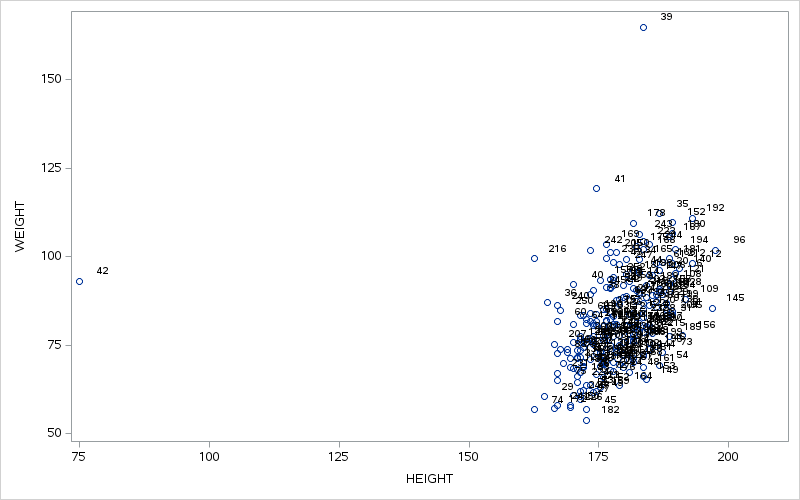
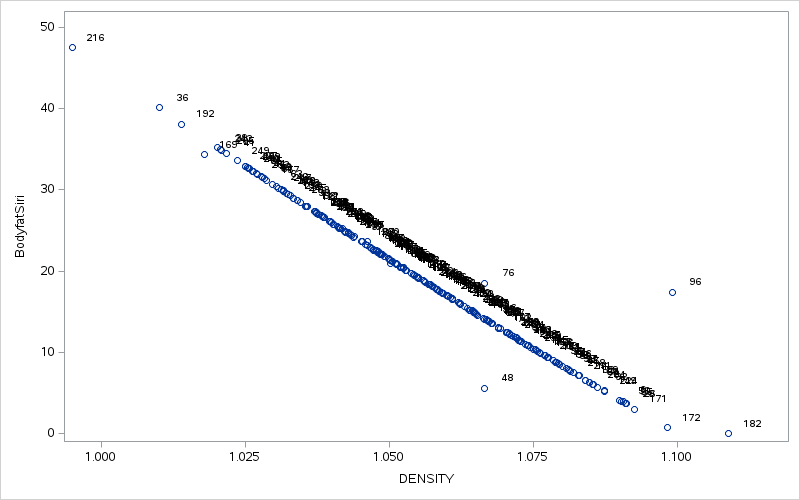

In [7]:
%%SAS sas_sess

/* check any outliers between weight and height */
PROC sgscatter  DATA = my_bodyfat;
   PLOT weight*height / datalabel = obs;

RUN; 
/* check any outliers between Density and BodyfatSiri */
PROC sgscatter  DATA = my_bodyfat;
   PLOT BodyfatSiri*Density / datalabel = obs;

RUN; 

### As we can see, young-adults with lower body fat tend to have higher body density, seniors with high body fat tend to have low body density.

### anomaly points
case 42 has a man weighing over 200 pounds who is less than 3 feet tall. 

Since it is physically impossible for a human to live with no bodyfat and equations of bodyfatBrozek and bodyfatSiri have an upper limit on density of approximately 1.1, the density value of 1.1089 for case 182 is highly suspect.

    case 48, 96,and 216 also suspected
    
    https://stat-ata-asu.github.io/PredictiveModelBuilding/BFdata.html

In [8]:
%%SAS sas_sess

/* remove case_no 42 48, 96, 216 and 182 */

data my_bodyfat2 ;
    set my_bodyfat;
    case_no = put(obs, 3.);
    format case_no $3.;
    DROP obs;
    if obs in (42, 48,96, 182, 216) then delete;

RUN;

ods select Variables;
proc contents data=my_bodyfat2;
    run;
ods select default;

In [9]:
# Using python, transfer data between SAS Data Sets and Pandas Data Frames
# sas_sess.sasdata(table='my_bodyfat', libref='work')  # 'SASdata' object
# # convert 'SASdata' object to pandas dataframe format
#   df = SASdata.to_df_DISK(dtype=str)
#
bodyfat_df =  sas_sess.sd2df(table='my_bodyfat2',libref='work')
bodyfat_df.head(10)

DENSITY  BodyfatSiri   AGE      HEIGHT     WEIGHT       NECK       CHEST  \
0   1.0708    12.300000  23.0  172.085007  69.966621  36.200001   93.099998   
1   1.0853     6.100000  22.0  183.514999  78.584877  38.500000   93.599998   
2   1.0414    25.299999  22.0  168.274994  69.853218  34.000000   95.800003   
3   1.0751    10.400000  26.0  183.514999  83.801193  37.400002  101.800003   
4   1.0340    28.700001  24.0  180.975006  83.574387  34.400002   97.300003   
5   1.0502    20.900000  24.0  189.865005  95.367798  39.000000  104.500000   
6   1.0549    19.200001  26.0  177.164993  82.100220  36.400002  105.099998   
7   1.0704    12.400000  25.0  184.149994  79.832260  37.799999   99.599998   
8   1.0900     4.100000  25.0  187.960007  86.636139  38.099998  100.900002   
9   1.0722    11.700000  23.0  186.690002  89.924690  42.099998   99.599998   

     ABDOMEN2         HIP      THIGH  ...      WRIST       bmi  \
0   85.199997   94.500000  59.000000  ...  17.100000  1.660964   
1   83.000000   98.699997  58.700001  ...  18.200001  1.640405   
2   87.900002   99.199997  59.599998  ...  16.600000  1.734214   
3   86.400002  101.199997  60.099998  ...  18.200001  1.749292   
4  100.000000  101.900002  63.200001  ...  17.700001  1.793871   
5   94.400002  107.800003  66.000000  ...  18.799999  1.859804   
6   90.699997  100.300003  58.400002  ...  17.700001  1.838839   
7   88.500000   97.099998  60.000000  ...  18.799999  1.654971   
8   82.500000   99.900002  62.900002  ...  18.200001  1.723945   
9   88.599998  104.099998  63.099998  ...  19.200001  1.813812   

   heightInMeters  weightInKG  BodyfatBrozek  FatFreeWeight     Density_cat  \
0        4.370959   31.736859      12.583734      61.162208    High density   
1        4.661281   35.646100       6.881741      73.176870    High density   
2        4.274185   31.685420      24.632360      52.646722     Low density   
3        4.661281   38.012221      10.876759      74.686340    High density   
4        4.596765   37.909342      27.772904      60.363352     Low density   
5        4.822571   43.258833      20.955215      75.383271  Medium density   
6        4.499991   37.240660      19.016398      66.487715  Medium density   
7        4.677410   36.211913      12.743199      69.659076  Medium density   
8        4.774184   39.298153       5.066042      82.247116    High density   
9        4.741926   40.789839      12.026474      79.109921    High density   

     Fat_value_cat       age_cat  case_no  
0     Low body fat  young adults        1  
1     Low body fat  young adults        2  
2  Medium body fat  young adults        3  
3     Low body fat  young adults        4  
4    High body fat  young adults        5  
5  Medium body fat  young adults        6  
6  Medium body fat  young adults        7  
7     Low body fat  young adults        8  
8     Low body fat  young adults        9  
9     Low body fat  young adults       10  

[10 rows x 24 columns]

In [10]:
type(bodyfat_df)

pandas.core.frame.DataFrame

In [11]:
bodyfat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DENSITY         247 non-null    float64
 1   BodyfatSiri     247 non-null    float64
 2   AGE             247 non-null    float64
 3   HEIGHT          247 non-null    float64
 4   WEIGHT          247 non-null    float64
 5   NECK            247 non-null    float64
 6   CHEST           247 non-null    float64
 7   ABDOMEN2        247 non-null    float64
 8   HIP             247 non-null    float64
 9   THIGH           247 non-null    float64
 10  KNEE            247 non-null    float64
 11  ANKLE           247 non-null    float64
 12  ExtendBiceps    247 non-null    float64
 13  FOREARM         247 non-null    float64
 14  WRIST           247 non-null    float64
 15  bmi             247 non-null    float64
 16  heightInMeters  247 non-null    float64
 17  weightInKG      247 non-null    flo

In [12]:
bodyfat_col_list=list(bodyfat_df.columns.values.tolist()) # Using tolist() method with values with given the list of columns

bodyfat_col_list

['DENSITY',
 'BodyfatSiri',
 'AGE',
 'HEIGHT',
 'WEIGHT',
 'NECK',
 'CHEST',
 'ABDOMEN2',
 'HIP',
 'THIGH',
 'KNEE',
 'ANKLE',
 'ExtendBiceps',
 'FOREARM',
 'WRIST',
 'bmi',
 'heightInMeters',
 'weightInKG',
 'BodyfatBrozek',
 'FatFreeWeight',
 'Density_cat',
 'Fat_value_cat',
 'age_cat',
 'case_no']

### Any missing data

In [13]:
%%SAS sas_sess
proc format;
 value $missing_char
              ' '  = 'Missing'
              other = 'Present'
    ;
 value missing_num
    . = 'Missing'
    other = 'Present'
    ;
run;

proc freq data = my_bodyfat2;
 tables _all_ /missing;
 format _character_ $missing_char. _numeric_ missing_num.;
run;  

### Generate scatter plots and correlations for the VAR variables Age, Weight, and Height, and the circumference measures Neck, Chest, Abdomen2, Hip, Thigh, Knee, Ankle, ExtendBiceps, Forearm, and Wrist versus the WITH variable, BodyFatSiri


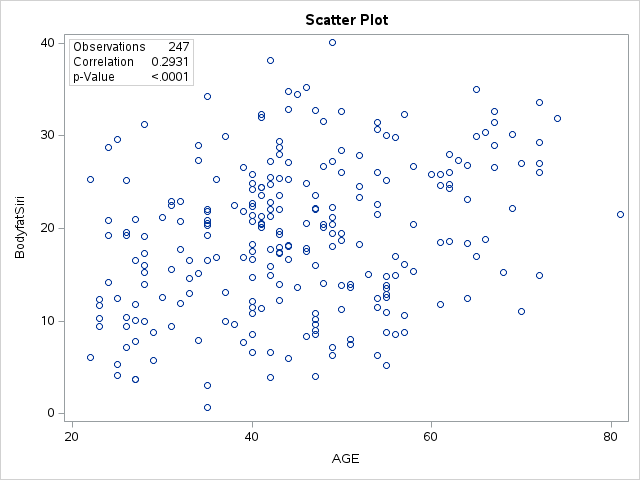
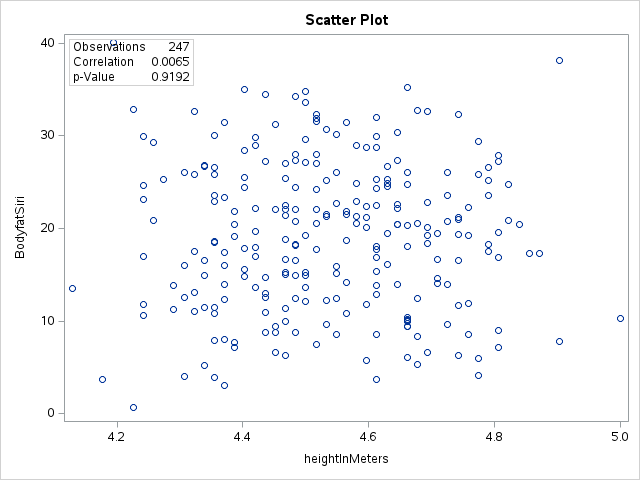
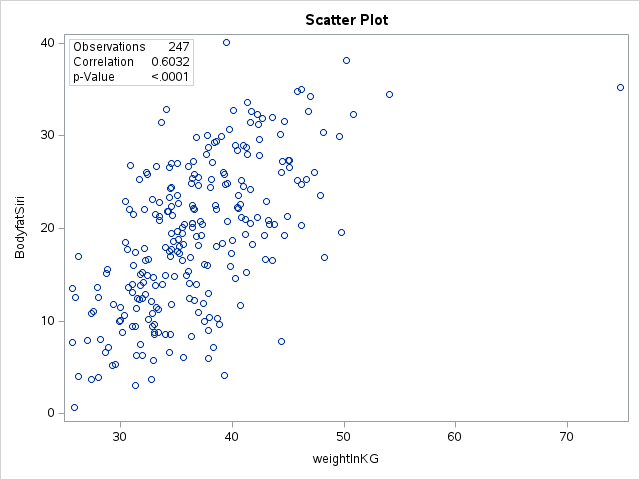
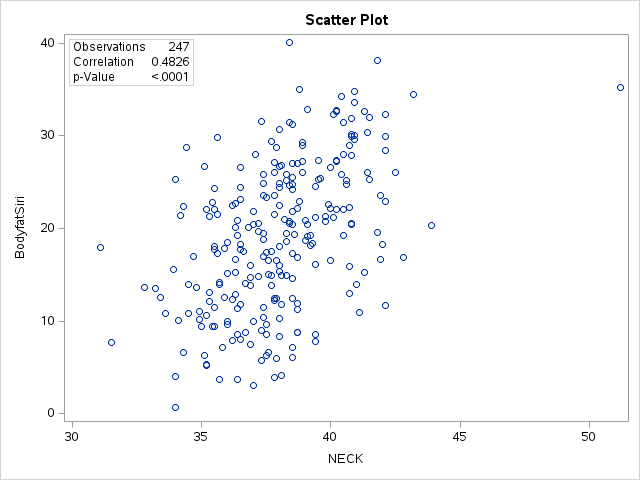
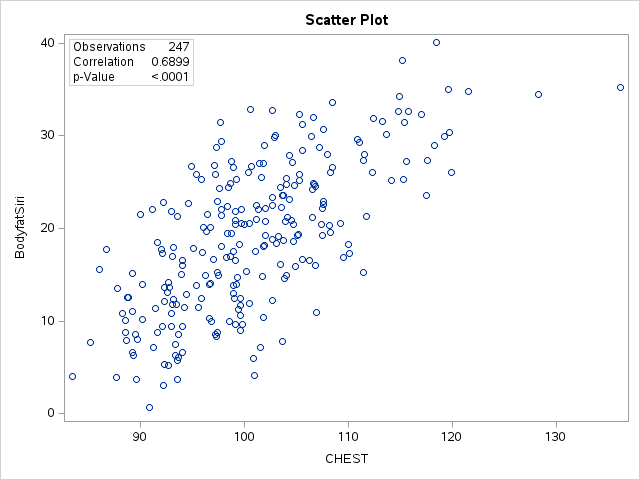
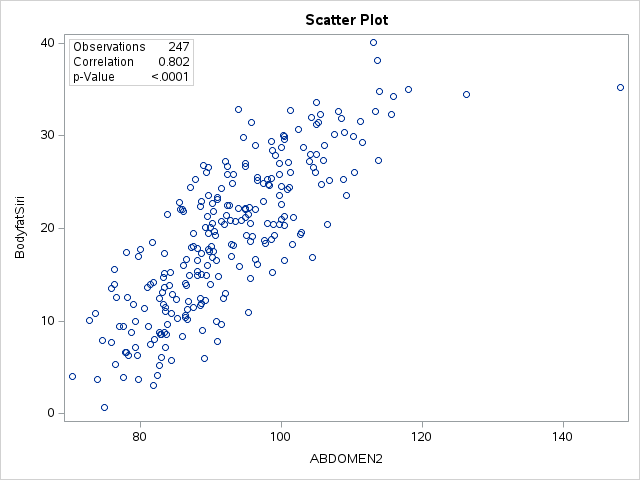
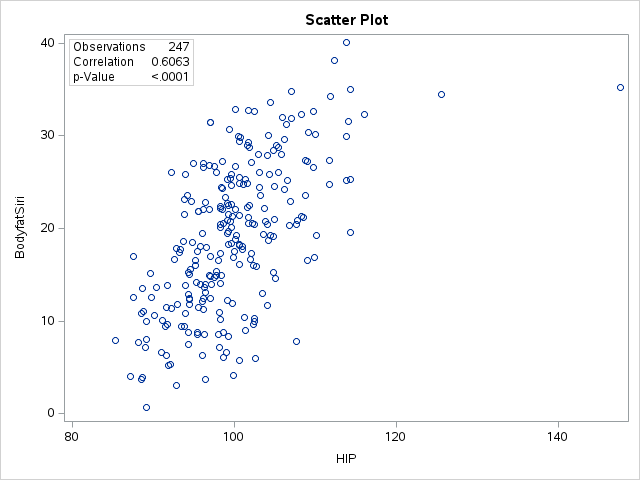
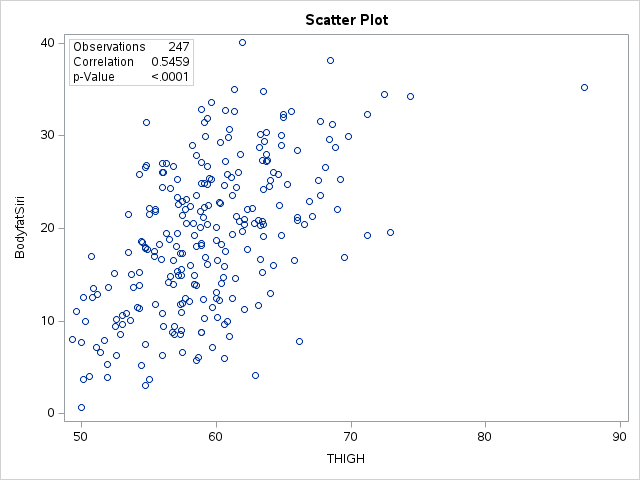
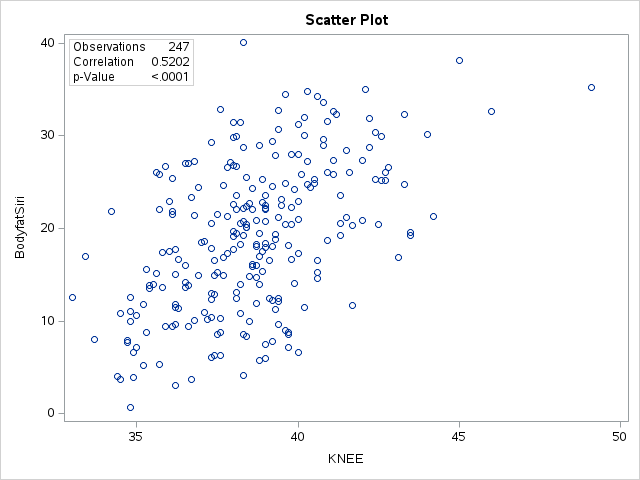
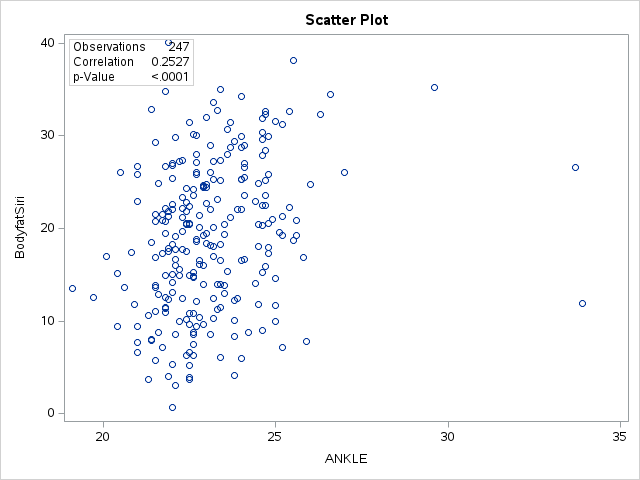
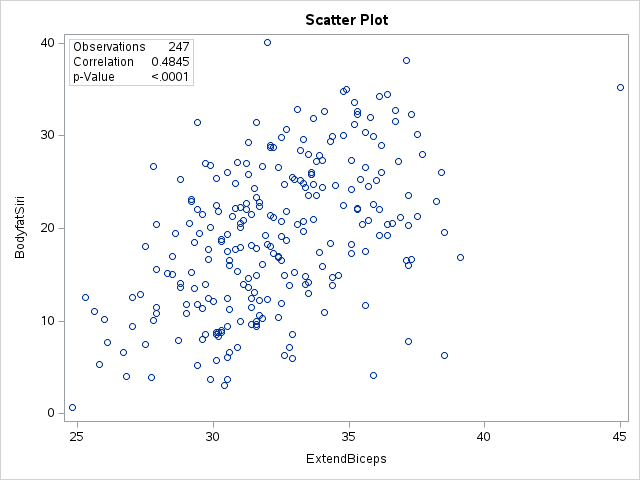
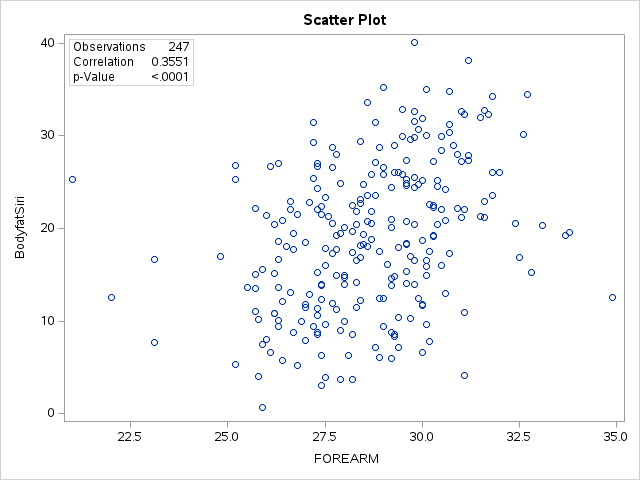
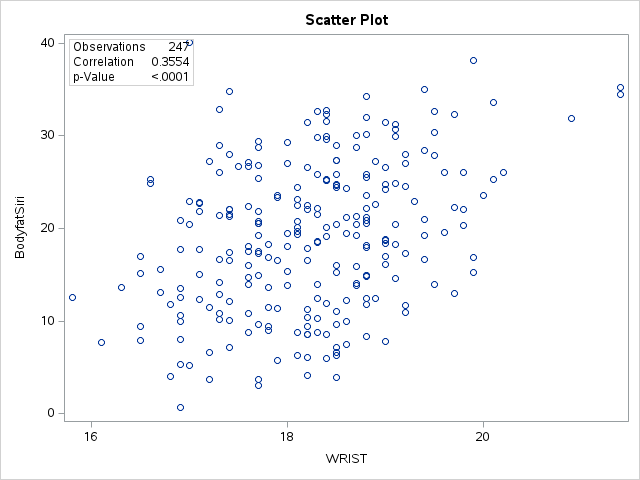

In [57]:
%%SAS sas_sess

%let interval=Age heightInMeters weightInKG Neck Chest Abdomen2 Hip 
              Thigh Knee Ankle ExtendBiceps Forearm Wrist;


proc corr data=my_bodyfat2
          plots(only)=scatter(nvar=all ellipse=none);
   var &interval;
   with BodyFatSiri;
   id case_no;
   title "Correlations and Scatter Plots";
run;

/* **IMPORTANT: For PROC CORR, ODS Graphics will display a maximum of 10 VAR variable plots at a time. */
    
%let interval=ExtendBiceps Forearm Wrist;
ods select scatterplot;
proc corr data=my_bodyfat2
          plots(only)=scatter(nvar=all ellipse=none);
   var &interval;
   with BodyFatSiri;
   id case_no;
   title "Correlations and Scatter Plots";
run;

###  Height seems to be the only variable that shows no real linear relationship. Age and Ankle show little linear trend. Abdomen, with r=0.802, is the variable with the highest correlation with BodyFatSiri. The p-value is <.0001.

### Use the BEST= option to select only the highest five correlation per variable

In [58]:
%%SAS sas_sess

ods graphics off;
%let interval=Age heightInMeters weightInKG Neck Chest Abdomen2 Hip 
              Thigh Knee Ankle ExtendBiceps Forearm Wrist;

proc corr data=my_BodyFat2 
          nosimple 
          best=5
          out=pearson;  /* output pearson correlations result */
   var &interval;
   title "Correlations of Predictors";
run;

ods graphics on

### Several relationships appear to have high correlations (such as those among Hip, Thigh, and Knee). Weight seems to correlate highly with all circumference variables.

### Plot correlation matrix

In [59]:

%%SAS sas_sess
/* from https://gist.github.com/statgeek/566dda98173a5a28a6e4147317547959 
       https://learn.sas.com/pluginfile.php/7660/mod_resource/content/2/apsoln.htm 
    */
/* Use the pearson data set to print only the correlations whose absolute values are 0.70 and above, 
    or note them with an asterisk in the full correlation table.
    */
    
    
%let big=0.7;
proc format;
    value CorrSignif -0.0-<0.2 = "red"
        0.2-<0.4, -0.4-<-0.2 = "orange"
        0.4-<0.6, -0.6-<-0.4 = "yellow"
        0.6-<0.8, -0.8-<-0.6 = "lightgreen"
        0.8-<1.0, -1.0-<-0.8= "forestgreen"
        1, -1 = "White";
    picture correlations &big -< 1 = '009.99' (prefix="*")
                         -1 <- -&big = '009.99' (prefix="*")
                         -&big <-< &big = '009.99';
run;



proc print data=pearson style(column)={backgroundcolor= CorrSignif.} noobs;
    var _NAME_ &interval;
    where _type_="CORR";
    format &interval correlations.;
    ;
run;

<Axes: >

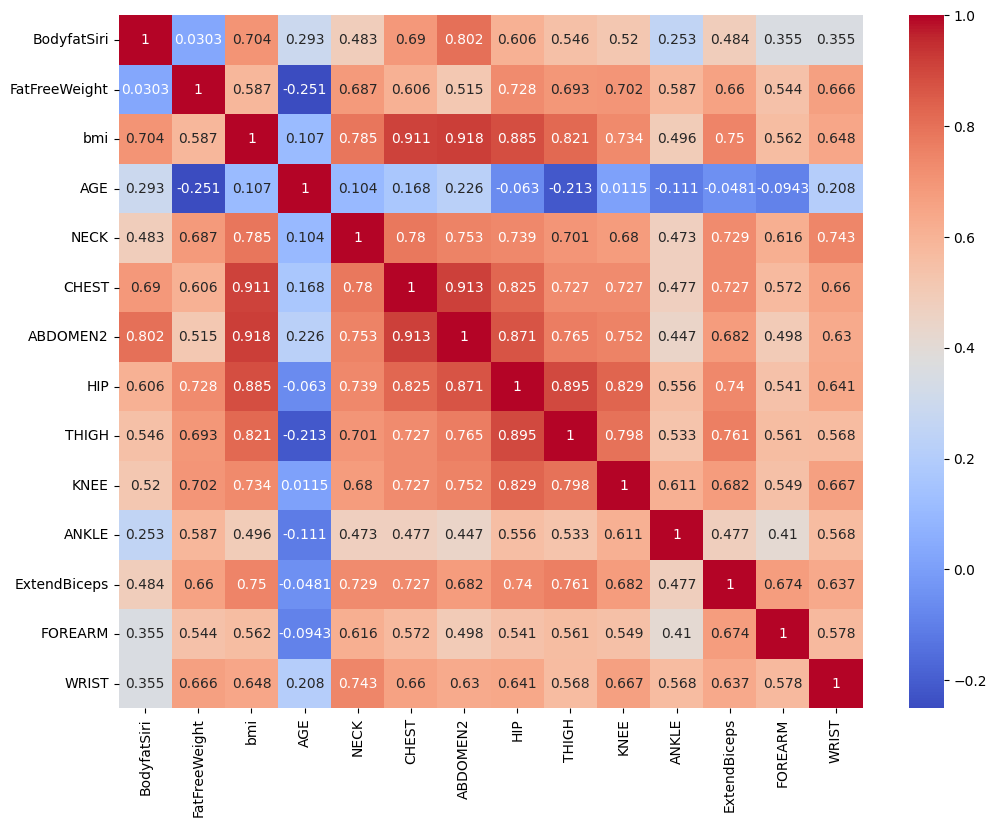

In [60]:
# using python to plot correlation matrix

import matplotlib.pyplot as plt

column_list = ['BodyfatSiri', 'FatFreeWeight', 'bmi', 'AGE', 'NECK', 'CHEST', 'ABDOMEN2', 'HIP', 'THIGH', 'KNEE',
               'ANKLE', 'ExtendBiceps', 'FOREARM', 'WRIST']
plt.figure(figsize=(12, 9))
sns.heatmap(bodyfat_df[column_list].corr(), annot = True, fmt='.3g',cmap= 'coolwarm')

### Potential solution to printing only the correlations whose absolute values are 0.7 and above:

In [61]:
%%SAS sas_sess


/* sort correlation output for transposition */
    proc sort data = pearson (where = (upcase(_type_) ="CORR"))
    out = CorrOut_sorted ;
    by _name_ ;
run ;

/*  transpose correlation matrix by row */
proc transpose data = CorrOut_sorted (rename = (_name_ =varnam)) out = CorrOut_transpsed
    prefix = corval ;
    by varnam ;    
    format &interval 5.2;
run ;

/* show only Strong correlations >0.7 */
%let cutoff = 0.7;
proc print data=CorrOut_transpsed;
    where abs(corval1) >= &cutoff AND corval1^=1;

run;

### Using PROC REG to Fit a Simple Linear Regression Model between Bodyfat and ABDOMEN2


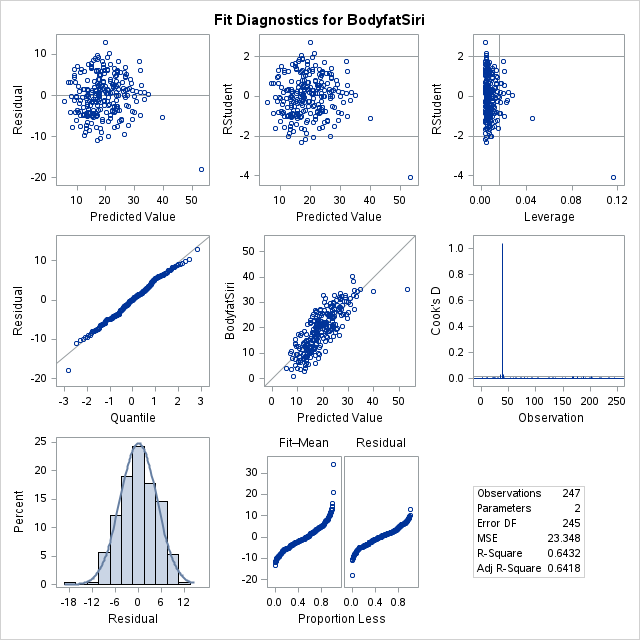
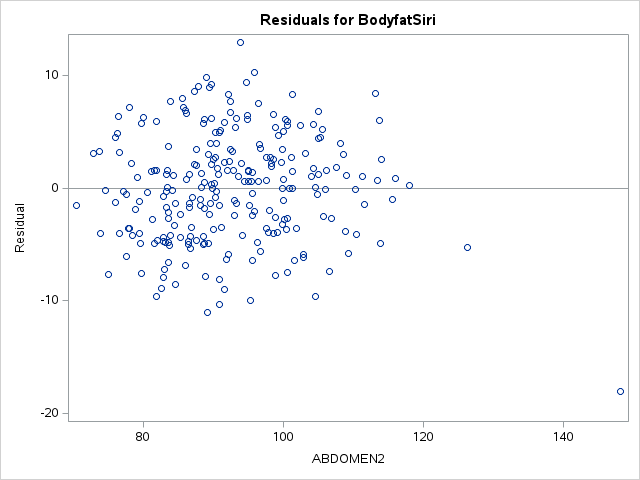
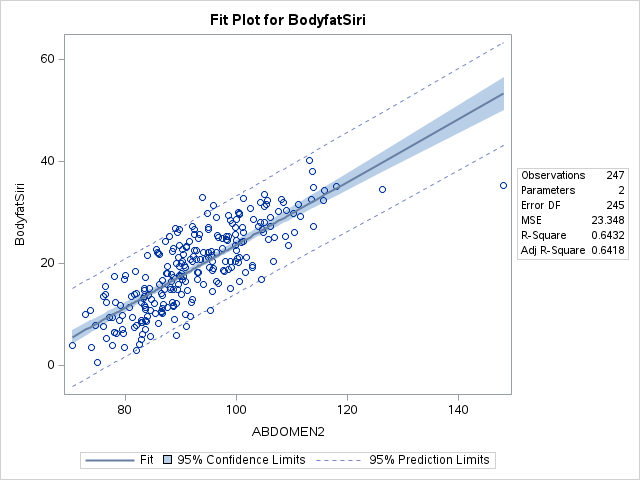

In [62]:
%%SAS sas_sess

proc reg data=my_BodyFat2;
   model BodyFatSiri=ABDOMEN2;
   title "Regression of % Body Fat on ABDOMEN2";
run;


title;

#### The value of the F statistic is 441.68 and the p-value is <.001. Therefore, you would reject the null hypothesis of no relationship, or a zero slope for ABDOMEN2.

#### The prediction regression equation is BodyFatSiri = -37.60903 + 0.61323 * ABDOMEN2.

#### The R-square value of 0.6432 can be interpreted to mean that 64.32% of the variability in BodyFatSiri can be explained by ABDOMEN2.

### Again, Generate scatter plots and correlations for the VAR variables Age, Weight, and Height, and the circumference measures Neck, Chest, Abdomen2, Hip, Thigh, Knee, Ankle, ExtendBiceps, Forearm, and Wrist versus the WITH variable, FatFreeWeight


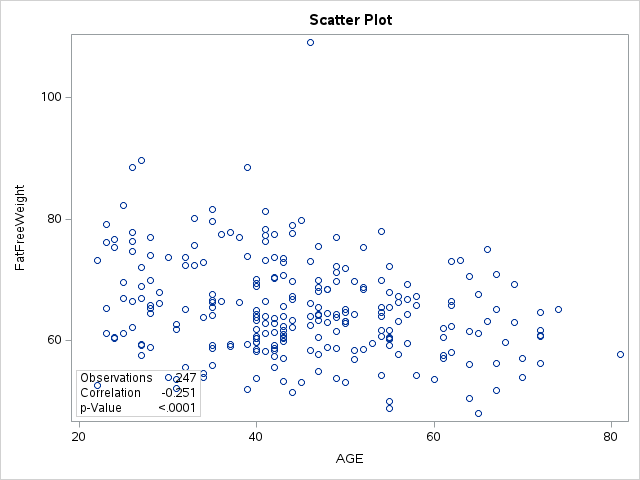
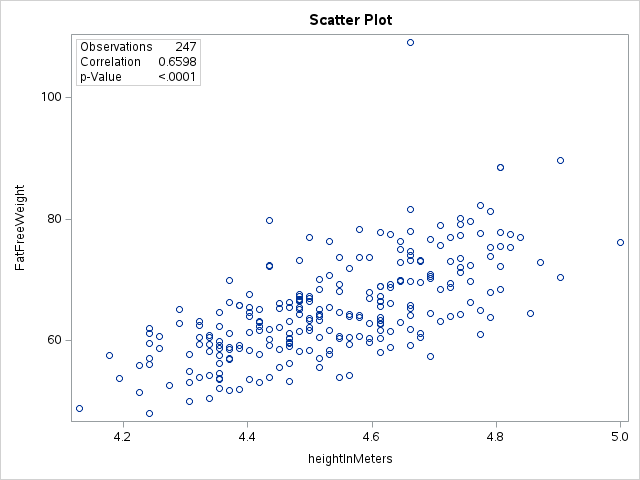
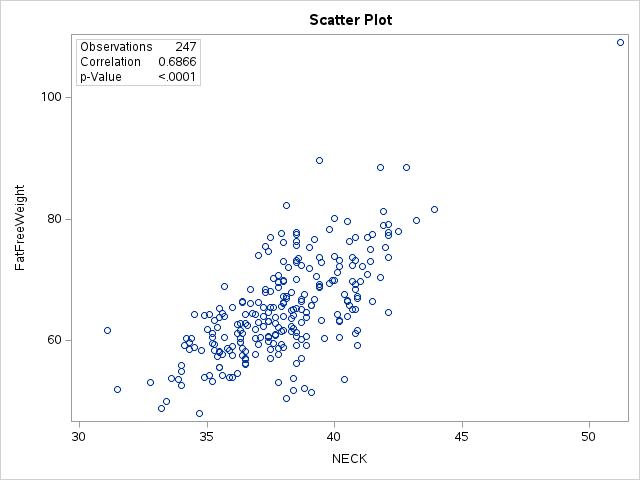
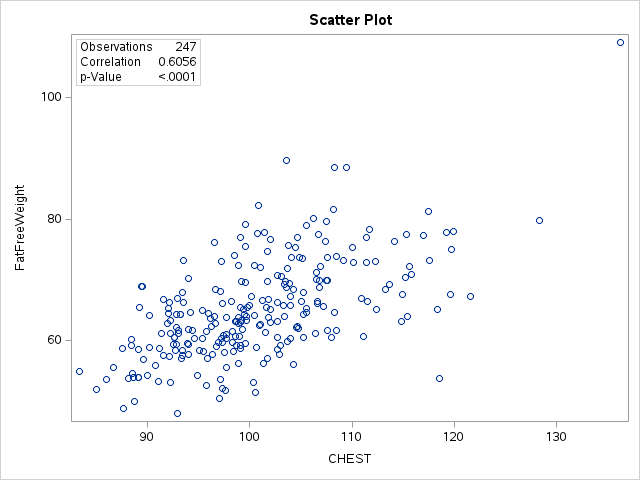
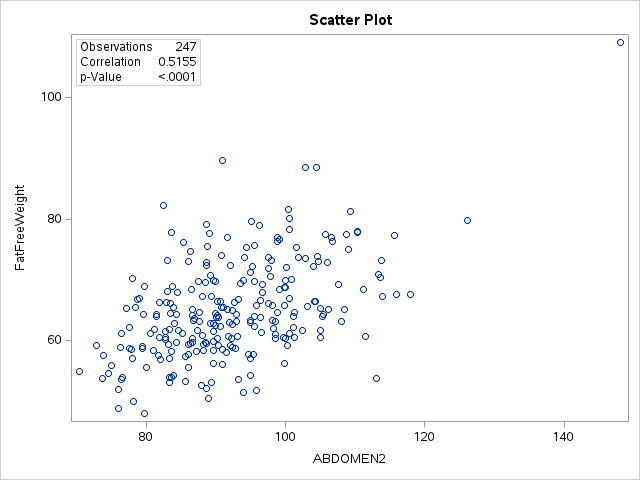
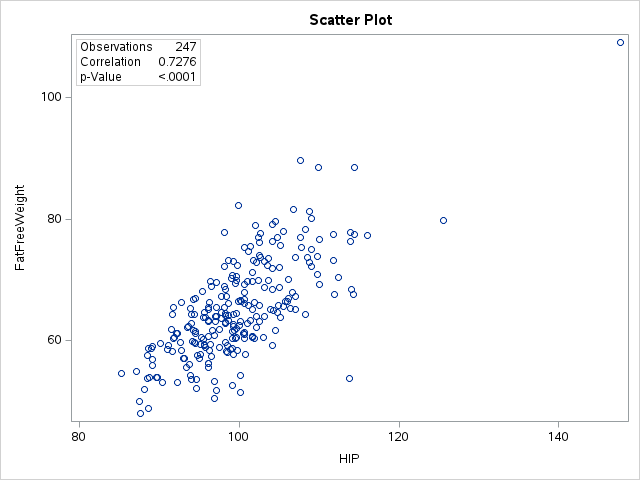
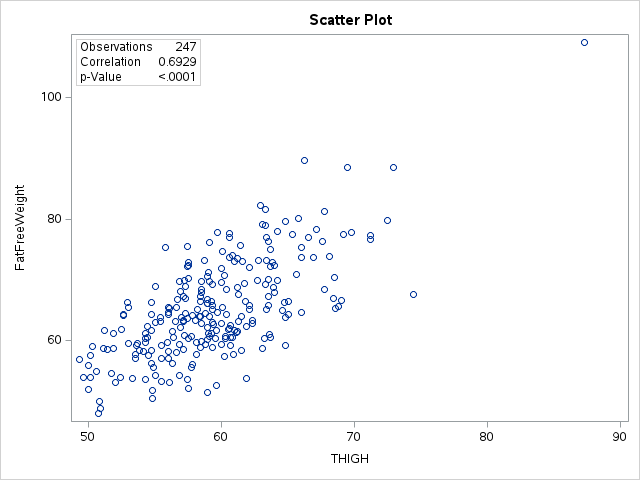
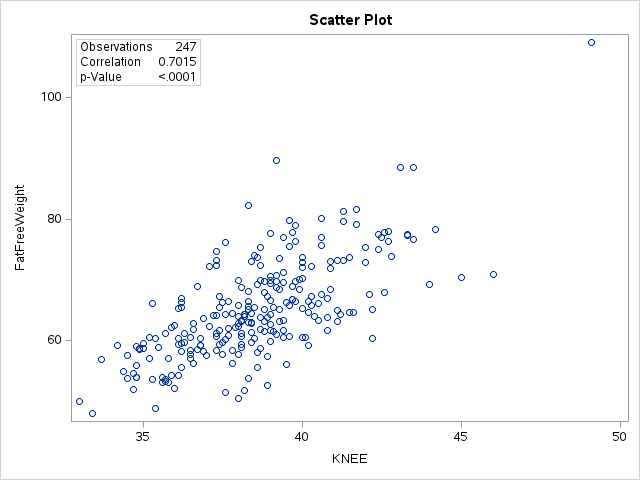
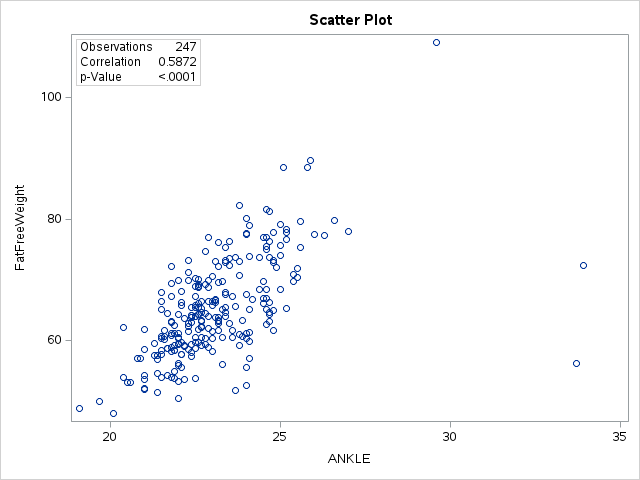
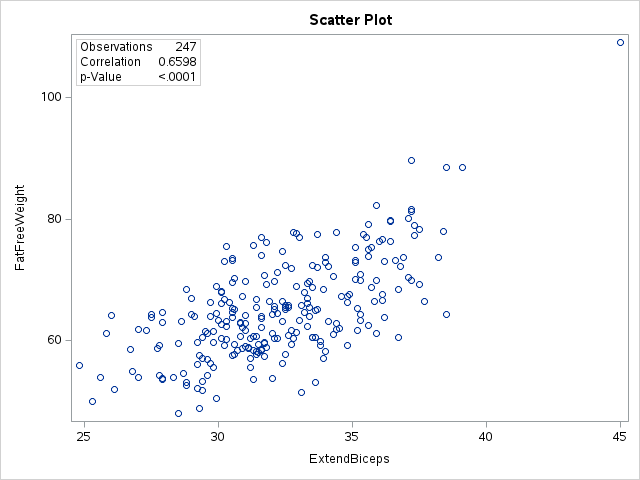
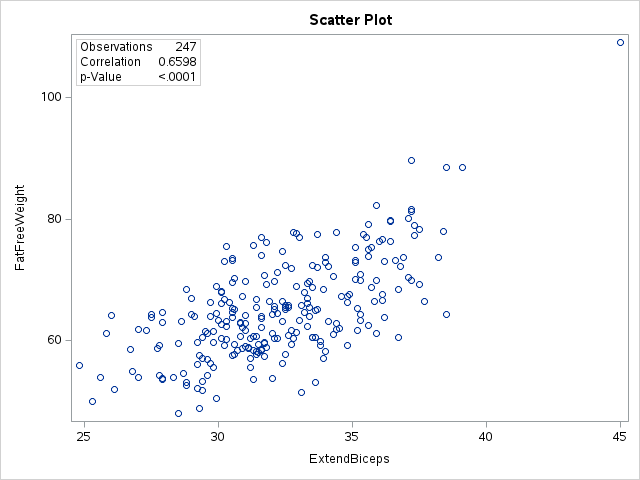
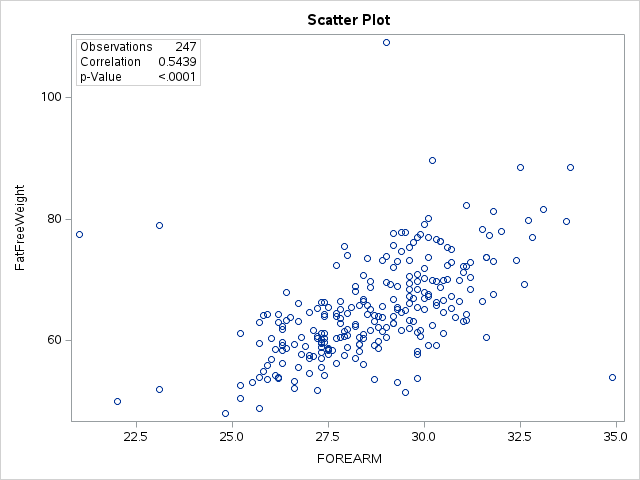
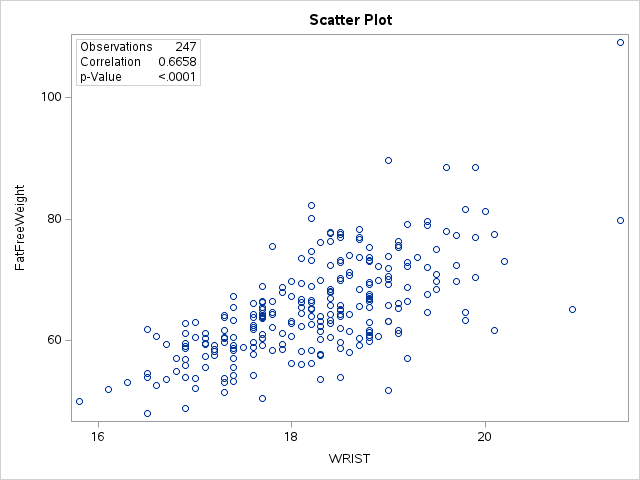

In [63]:
%%SAS sas_sess

%let interval=Age heightInMeters Neck Chest Abdomen2 Hip 
              Thigh Knee Ankle ExtendBiceps Forearm Wrist; /* exclude weightInKG */


proc corr data=my_bodyfat2
          plots(only)=scatter(nvar=all ellipse=none);
   var &interval;
   with FatFreeWeight;
   id case_no;
   title "Correlations and Scatter Plots for FatFreeWeight";
run;

/* **IMPORTANT: For PROC CORR, ODS Graphics will display a maximum of 10 VAR variable plots at a time. */
    
%let interval=ExtendBiceps Forearm Wrist;
ods select scatterplot;
proc corr data=my_bodyfat2
          plots(only)=scatter(nvar=all ellipse=none);
   var &interval;
   with FatFreeWeight;
   id case_no;
   title "Correlations and Scatter Plots for FatFreeWeight";
run;

### Using PROC REG to Fit a Simple Linear Regression Model between FatFreeWeight and Hip


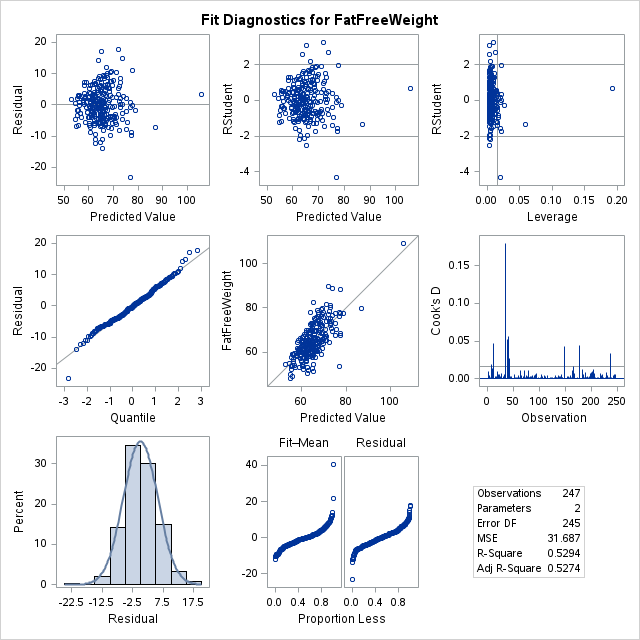
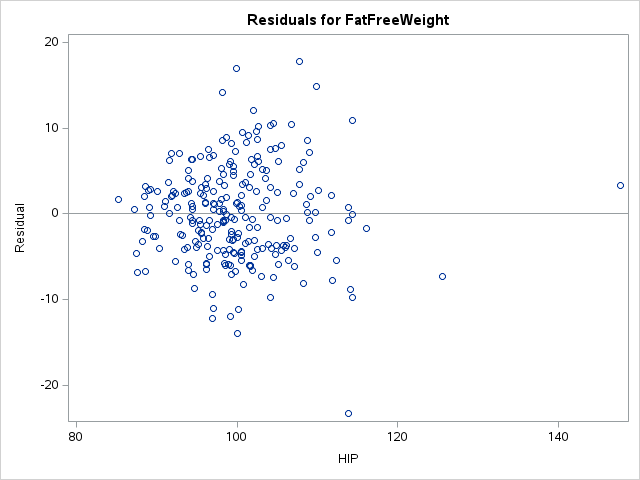
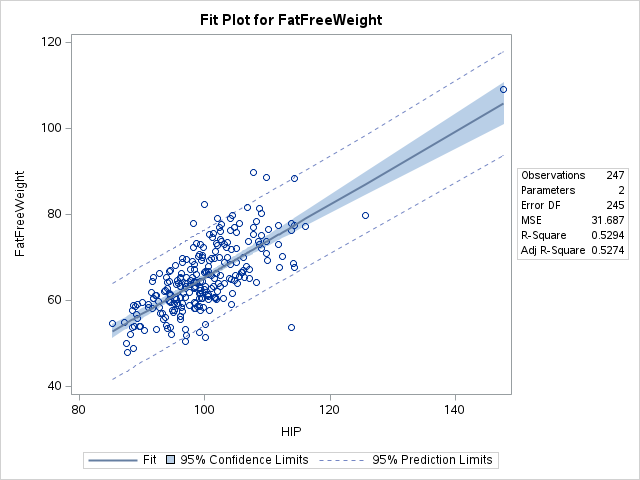

In [64]:
%%SAS sas_sess

proc reg data=my_BodyFat2;
   model FatFreeWeight=Hip;
   title "Regression of FatFreeWeight on Hip";
run;


title;

#### The R-square value of 0.5294 can be interpreted to mean that 52.94% of the variability in FatFreeWeight can be explained by Hip.

## Performing Multiple Regression Using PROC REG


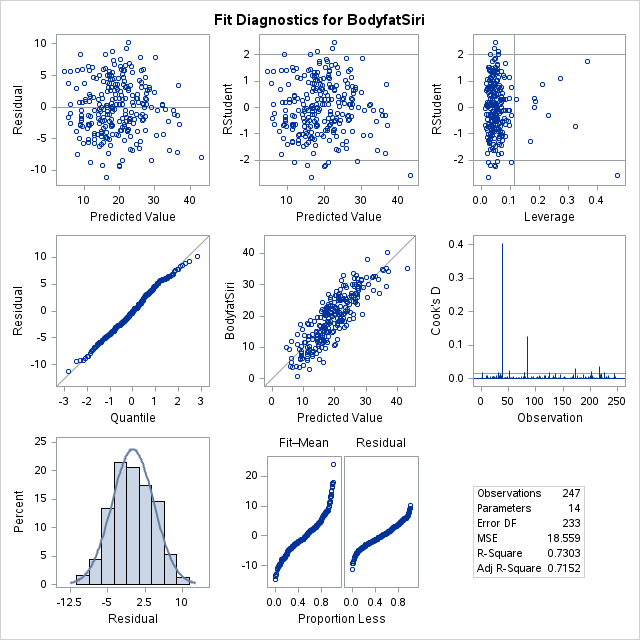
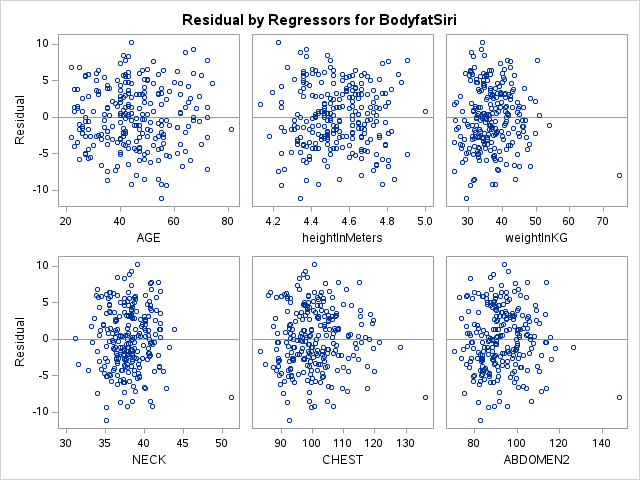
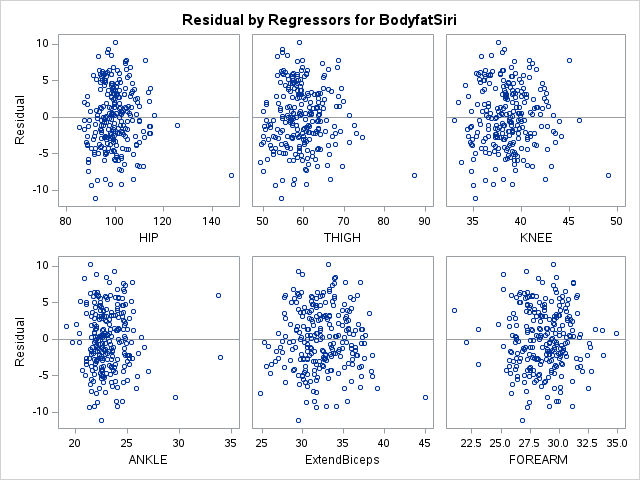
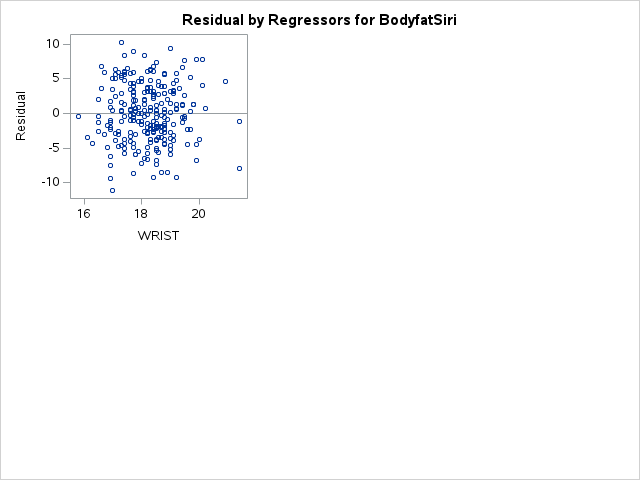

In [65]:
%%SAS sas_sess

proc reg data=my_bodyfat2;
    model BodyFatSiri=Age heightInMeters weightInKG Neck Chest Abdomen2 Hip 
              Thigh Knee Ankle ExtendBiceps Forearm Wrist;
    title 'Regression of % of BodyFat on All '
          'Predictors';
run;

#### There are key differences between the ANOVA table for this model and the one for the simple linear regression model. The degrees of freedom for the model are much higher, 13 versus 1. Also, the Mean Square model and the F ratio are much smaller.

#### Both the R-Square and the adjusted R-Square for the full models are larger than the simple linear regression. The multiple regression model explains almost 73.0% of the variation in the BodtFatSiri variable versus approximately 64.3% that is explained by the simple linear regression model.


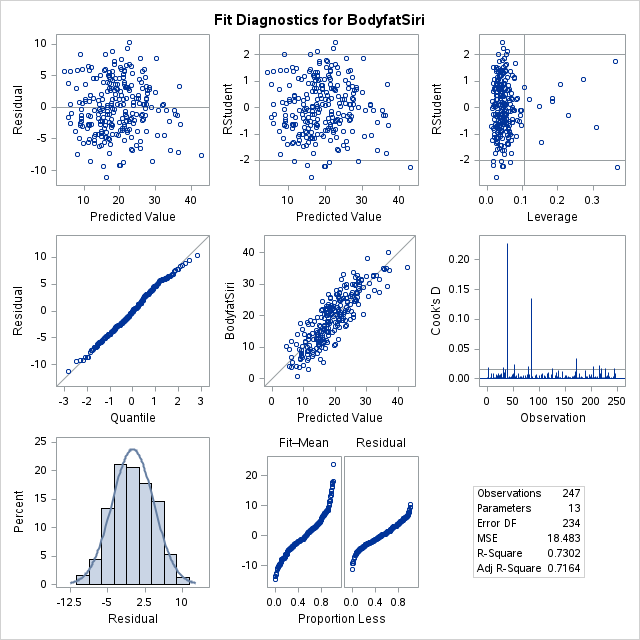
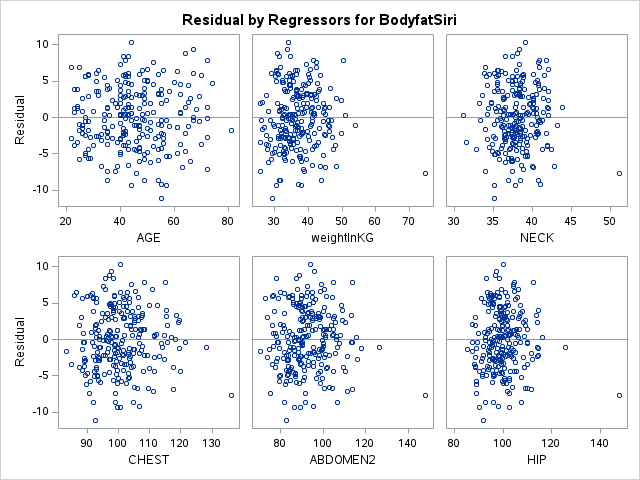
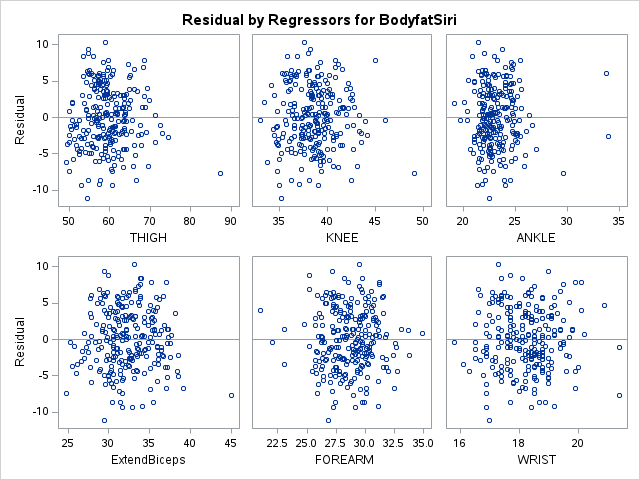

In [66]:
%%SAS sas_sess

/* rerun the model, eliminate the variables with the highest p-value*/
/* heightInMeters p-value (0.8437) */

proc reg data=my_bodyfat2;
    model BodyFatSiri=Age weightInKG Neck Chest Abdomen2 Hip 
              Thigh Knee Ankle ExtendBiceps Forearm Wrist;
    title 'Regression of PctBodyFat2 on All '
          'Predictors, Minus heightInMeters';
run;

#### The p-value for the model did not change to four decimal places. The R-Square showed essentially no change. The adjusted R-Square increased from .7152 to .7164. When an adjusted R-Square increases by removing a variable from the model, it strongly implies that the removed variable was not necessary. Some of the parameter estimates and their p-values changed slightly, but none to any large degree.


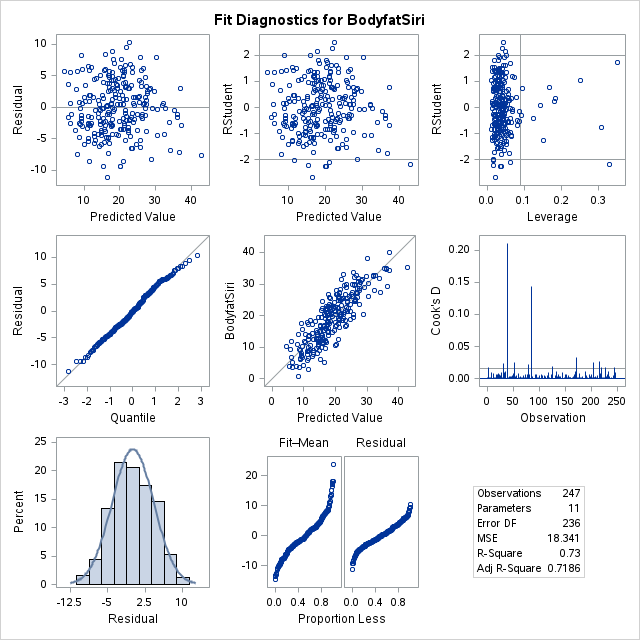
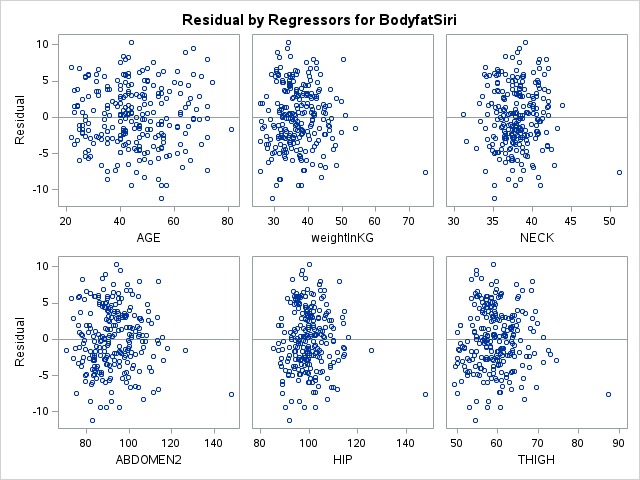
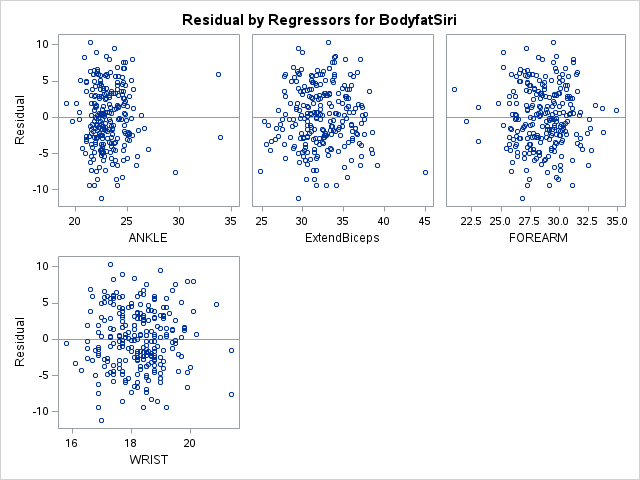

In [67]:
%%SAS sas_sess

/* rerun the model, eliminate the variables with the highest p-value*/
/* heightInMeters p-value (0.8437) 
Chest 0.7743
Knee 0.7727 
*/
proc reg data=my_bodyfat2;
    model BodyFatSiri=Age weightInKG Neck  Abdomen2 Hip 
              Thigh Ankle ExtendBiceps Forearm Wrist;
    title 'Regression of PctBodyFat2 on All '
          'Predictors, Minus heightInMeters, Chest, Knee';
run;

#### The ANOVA table did not change significantly. The R-Square remained essentially unchanged. The adjusted R-Square increased again. This confirms that the variable Chest and Knee did not contribute to explaining the variation in BodyFatSiri when the other variables were in the model.

### Using PROC GLMSELECT to Perform Stepwise Selection


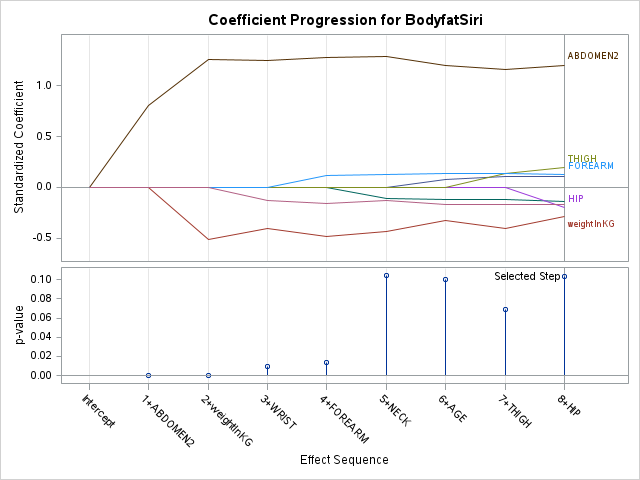
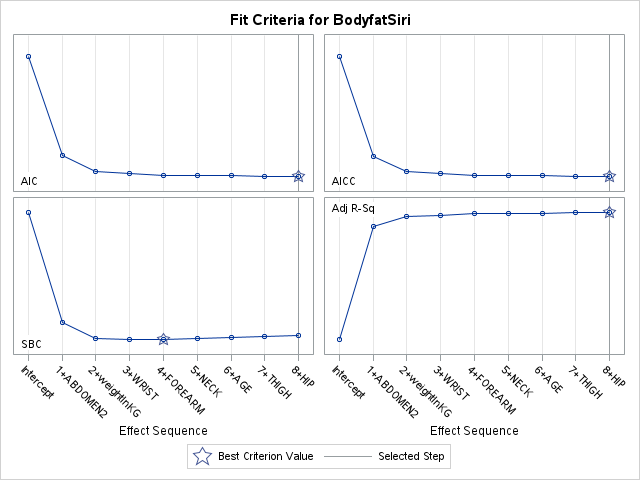
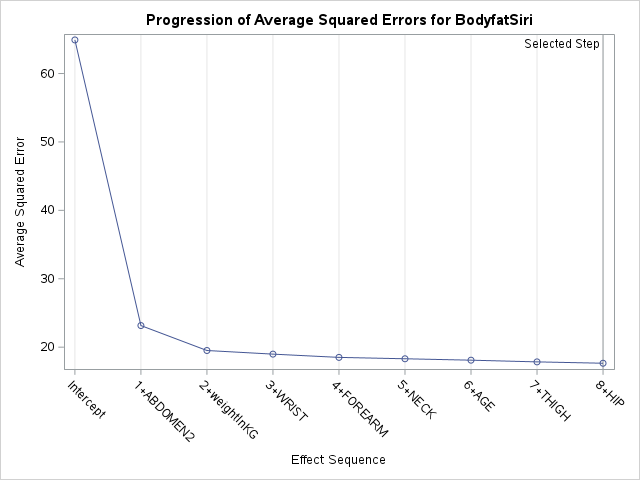

In [68]:
%%SAS sas_sess

proc glmselect data=my_bodyfat2 plots=all;
    STEPWISESL: model BodyFatSiri=Age heightInMeters weightInKG Neck Chest Abdomen2 Hip 
              Thigh Knee Ankle ExtendBiceps Forearm Wrist
                      / SELECTION=STEPWISE SELECT=SL;
    title 'SL STEPWISE Selection with BodyFatSiri';
run;

    In the results, notice the following:
        Selection stopped because the candidate for entry has SLE > 0.15 and the candidate for removal has SLS < 0.15.
        The stepwise selection process, using significance level, seems to select an Nine-effect model (including the intercept).
        The Coefficient panel shows that the standardized coefficients do not vary greatly when additional effects are added to the model.
        The Fit panel indicates that the best model, according to AIC, AICC, and adjusted R-square, is the final model viewed during the selection process. SBC shows a minimum at step four.
        The parameter estimates from the selected model are presented in the Parameter Estimates table.

### Select forward selection process (FORWARD)


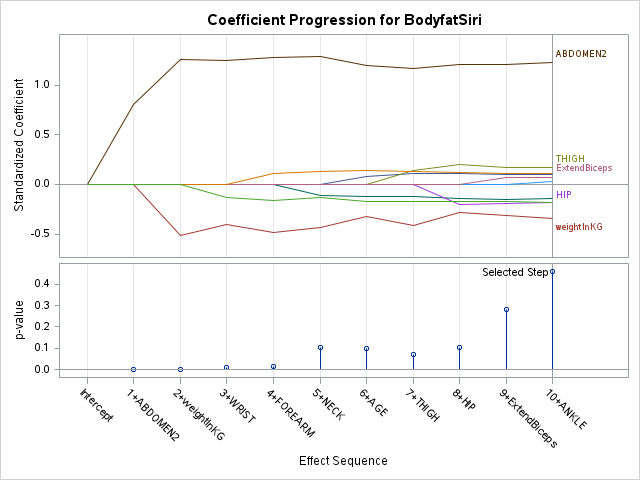
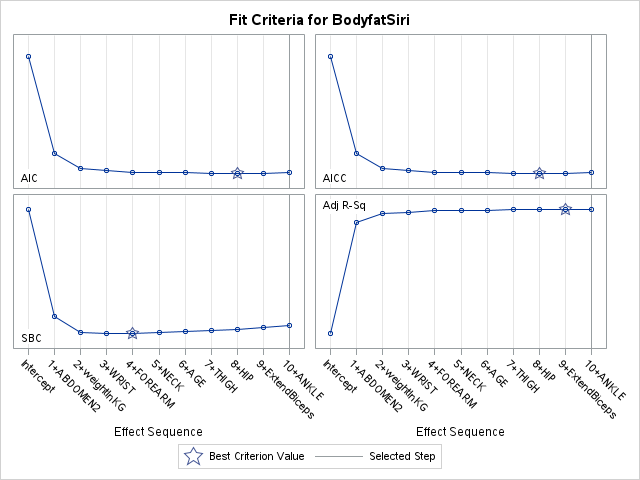
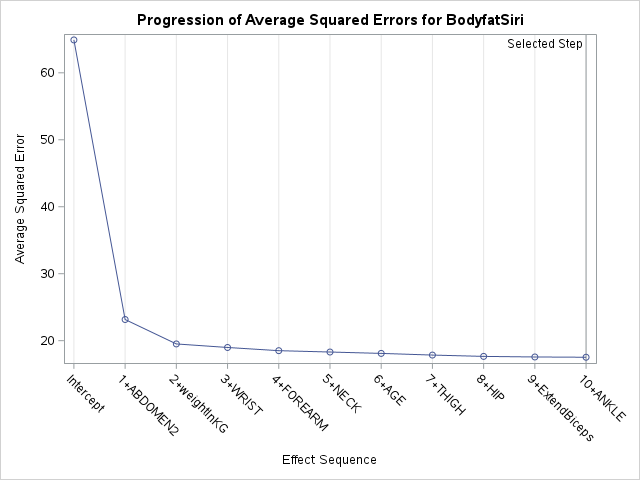

In [69]:
%%SAS sas_sess

proc glmselect data=my_bodyfat2 plots=all;
    FORWARDSL: model BodyFatSiri=Age heightInMeters weightInKG Neck Chest Abdomen2 Hip 
              Thigh Knee Ankle ExtendBiceps Forearm Wrist
                      / SELECTION=FORWARD SELECT=SL;
    title 'SL FORWARD Selection with BodyFatSiri';
run;

    In the results, notice the following:
        Selection stopped as the candidate for entry has SLE > 0.5.
        The forward selection process, using significance level, seems to select an 10-effect model (including the intercept).
        The Coefficient panel shows that the standardized coefficients do not vary greatly when additional effects are added to the model.
        The Fit panel indicates that the best models, according to AIC, AICC, adjusted R-square, and SBC, are at various steps in the selection progression.
        The parameter estimates from the selected model are presented in the Parameter Estimates table.

#### a model using forward selection and a significance-level-for-entry criterion of 0.05


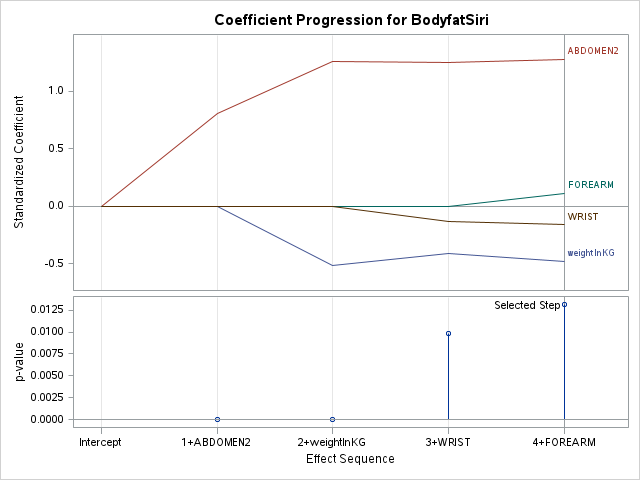
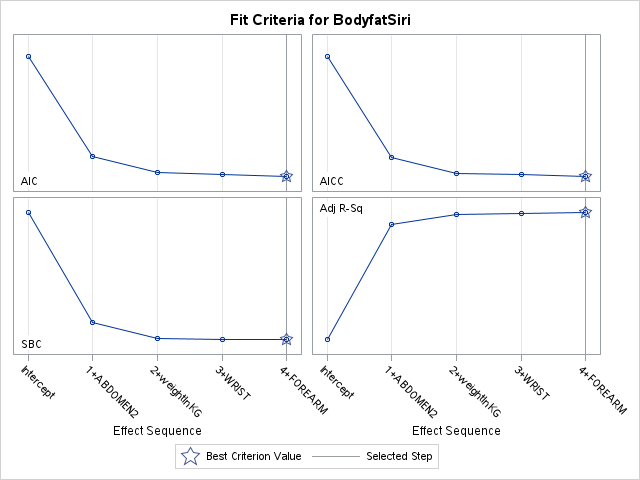
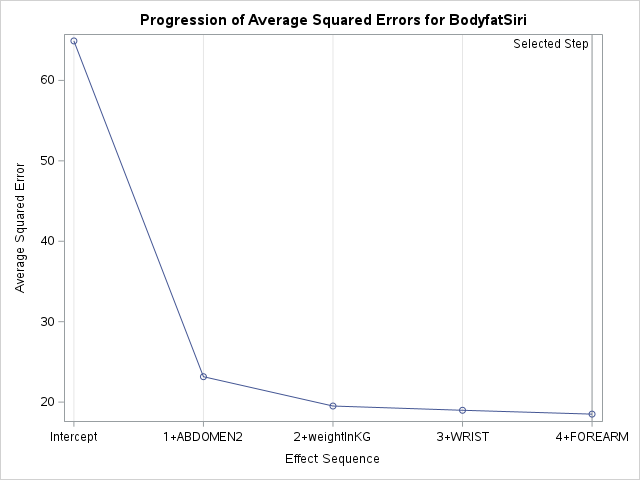

In [70]:
%%SAS sas_sess

proc glmselect data=my_bodyfat2 plots=all;
    FORWARDSL: model BodyFatSiri=Age heightInMeters weightInKG Neck Chest Abdomen2 Hip 
              Thigh Knee Ankle ExtendBiceps Forearm Wrist
                      / SELECTION=FORWARD SELECT=SL
                SLENTRY=0.05;
    title 'SL FORWARD (0.05) Selection with BodyFatSiri';
run;

#### The results show that, when the value of SLENTRY= is changed from the default to 0.05, the number of effects in the selected model is reduced to five (including the intercept).

### Using PROC GLMSELECT to Perform Other Model Selection Techniques
#### With the SELECTION=STEPWISE option, use SELECT=SBC


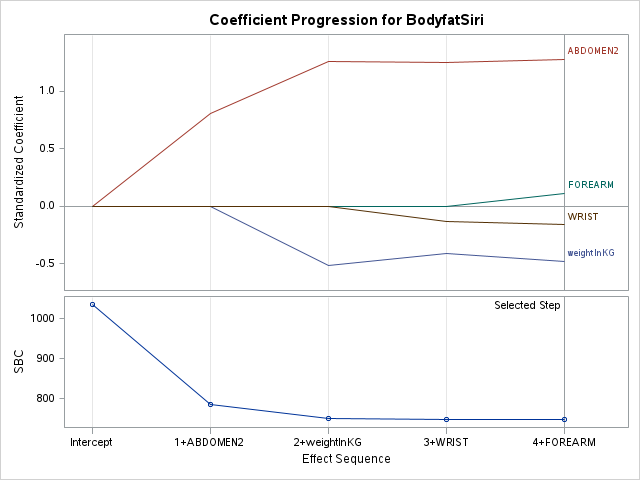
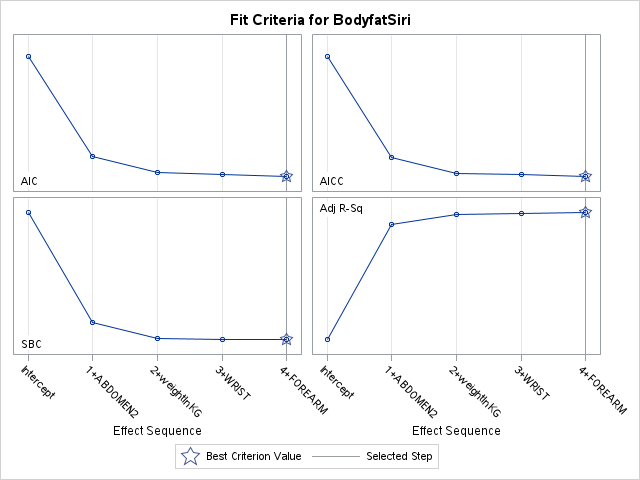
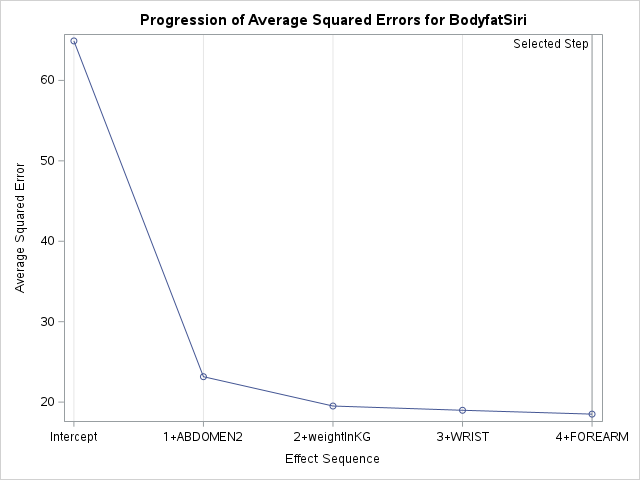

In [71]:
%%SAS sas_sess

proc glmselect data=my_bodyfat2 plots=all;
    STEPWISESL: model BodyFatSiri=Age heightInMeters weightInKG Neck Chest Abdomen2 Hip 
              Thigh Knee Ankle ExtendBiceps Forearm Wrist
                      / SELECTION=STEPWISE SELECT=SBC;
    title 'SBC STEPWISE Selection with BodyFatSiri';
run;

    In the results, notice the following:
        The stepwise selection process, using SELECT=SBC, seems to select a five-effect model (including the intercept).
        The Coefficient panel shows that the standardized coefficients do not vary greatly when additional effects are added to the model.
        The Fit panel indicates that the best model, according to AIC, AICC, adjusted R-square, and SBC, is the final model viewed during the selection process. 
        Remember that this statement compares only the models that were viewed in these steps of the selection process.
        The parameter estimates from the selected model are presented in the Parameter Estimates table.

#### With the SELECTION=STEPWISE option, use SELECT=AIC


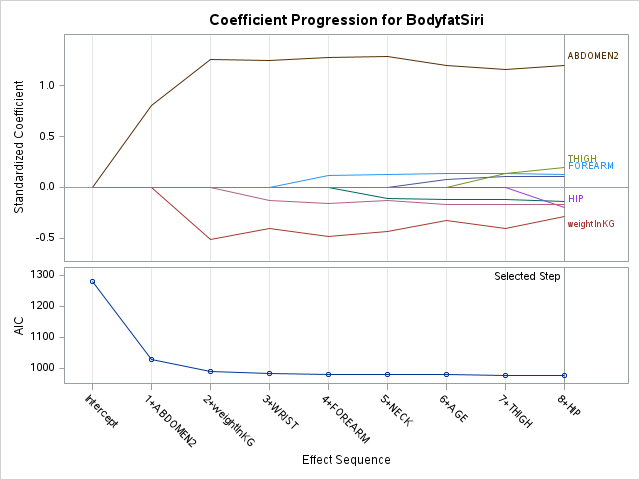
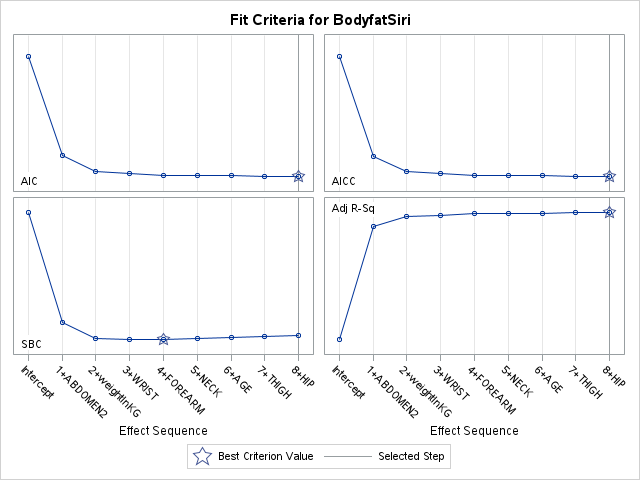
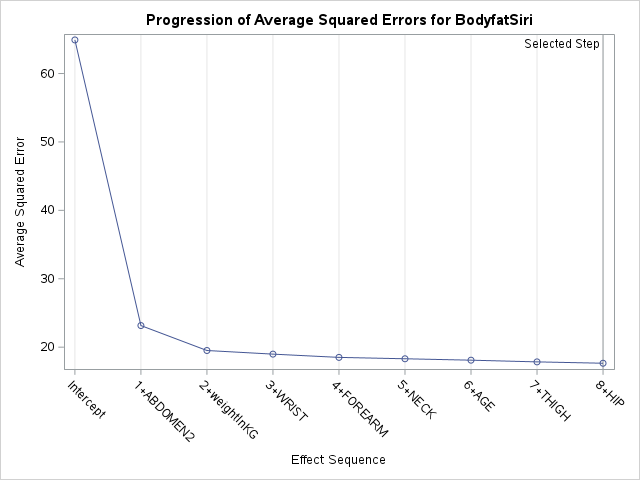

In [72]:
%%SAS sas_sess

proc glmselect data=my_bodyfat2 plots=all;
    STEPWISESL: model BodyFatSiri=Age heightInMeters weightInKG Neck Chest Abdomen2 Hip 
              Thigh Knee Ankle ExtendBiceps Forearm Wrist
                      / SELECTION=STEPWISE SELECT=AIC;
    title 'AIC STEPWISE Selection with BodyFatSiri';
run;

#### Using SELECT=AIC, the selected model contains nine effects (including the intercept).

### Using PROC REG to Examine Residuals


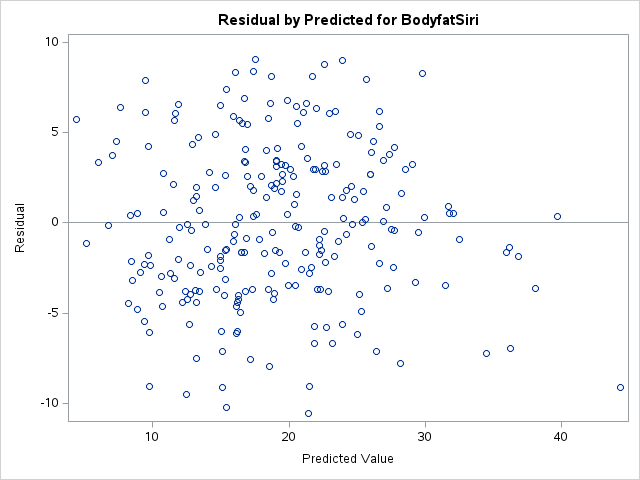
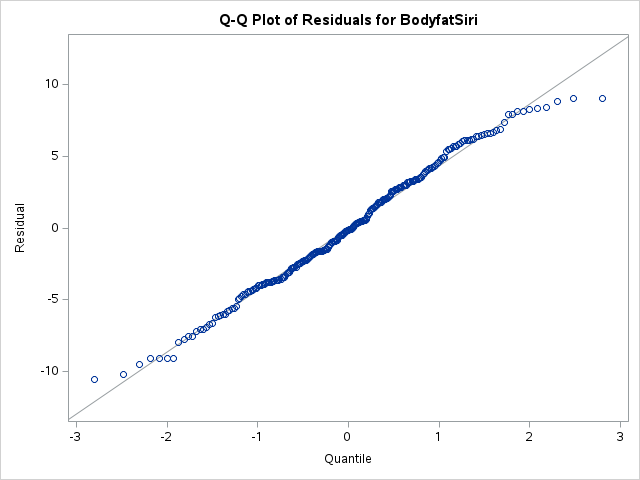
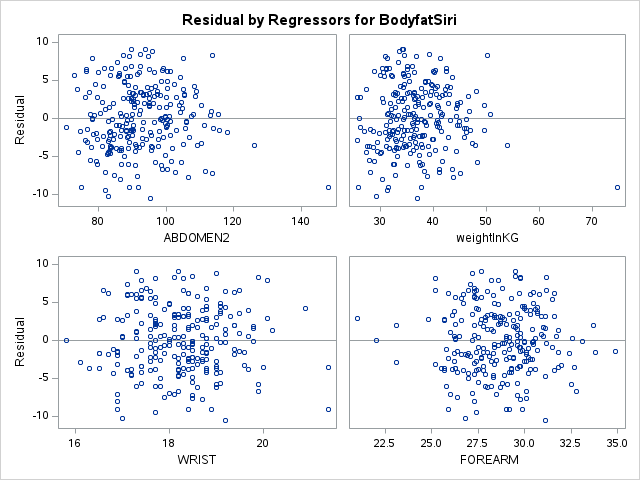

In [73]:
%%SAS sas_sess

proc reg data=my_bodyfat2 
         plots(only)=(QQ RESIDUALBYPREDICTED RESIDUALS);
   FORWARD: model BodyFatSiri = Abdomen2 weightInKG Wrist Forearm;
   id case_no;
   title 'FORWARD Model - Plots of Diagnostic Statistics';
run;

#### It doesn't appear that the data violate the assumption of constant variance. Also, the residuals show nice random scatter and indicate no problem with model specification. There are a few outliers for Wrist and Forearm, and one clear outlier in both Abdomen and Weight. The Q-Q plot indicate normality assumption seems to be met.

### Using PROC REG to Generate Potential Outliers


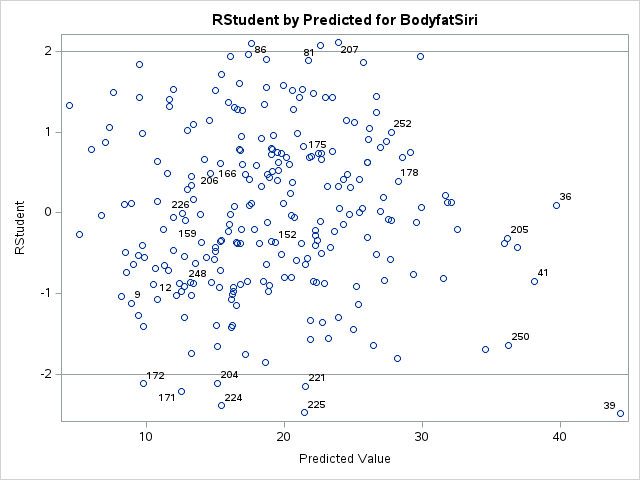
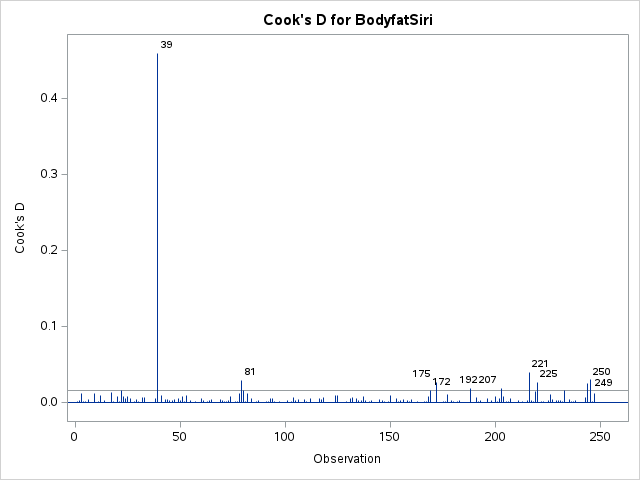
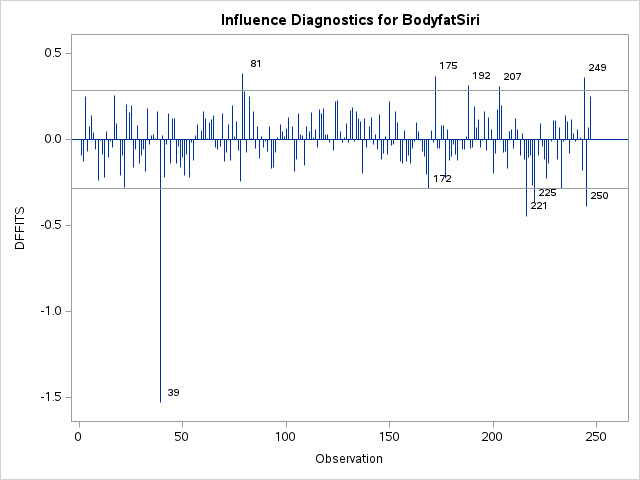
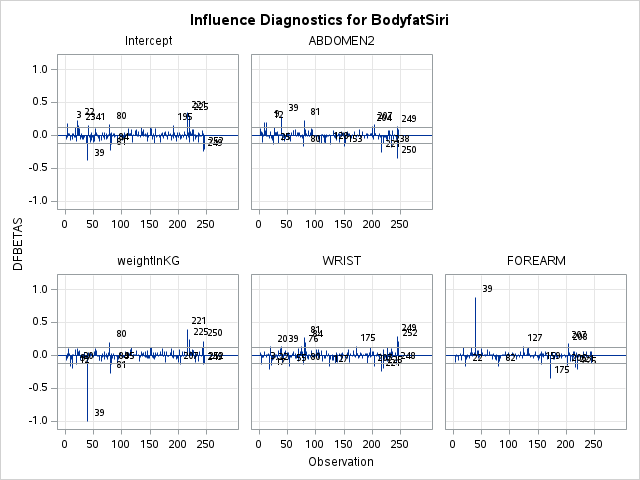

In [74]:
%%SAS sas_sess

/* Create plots to identify potential influential observations that are based on the suggested cutoff values */
ods graphics on;
ods output RSTUDENTBYPREDICTED=Rstud 
           COOKSDPLOT=Cook
           DFFITSPLOT=Dffits 
           DFBETASPANEL=Dfbs;
proc reg data=my_bodyfat2 
         plots(only label)=
              (RSTUDENTBYPREDICTED 
               COOKSD 
               DFFITS 
               DFBETAS);
   FORWARD: model BodyFatSiri
                 = Abdomen2 weightInKG Wrist Forearm;
   id case_no;
   title 'FORWARD Model - Plots of Diagnostic Statistics';
run;

Here are the results.

    In the RStudent by Predicted for BodyFatSiri scatter plot, only a modest number of observations are further than two standard error units from the mean of 0.
    In the Cook's D for BodyFatSiri plot, there are 11 labeled outliers, but observation 39 is clearly the most extreme.
    In the Influence Diagnostics for BodyFatSiri plot, the same observations are shown to be influential by the DFFITS statistic.
    In the panel plot, DFBETAS are particularly high for observation 39 on the parameters for Weight and Forearm circumference.


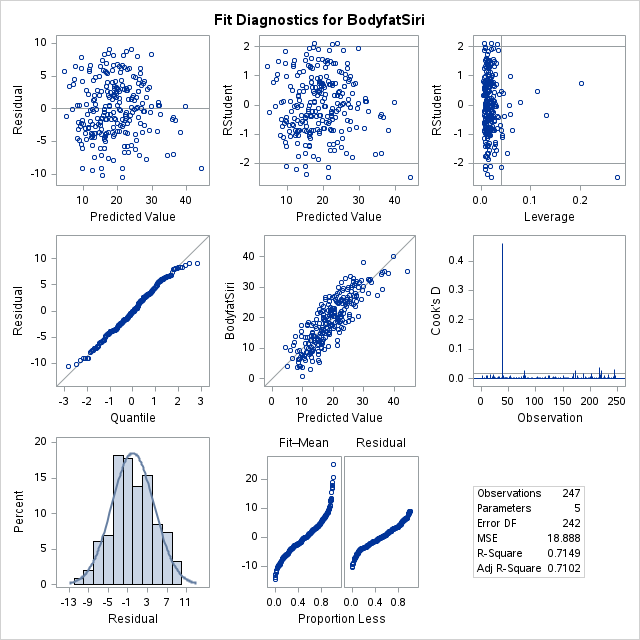
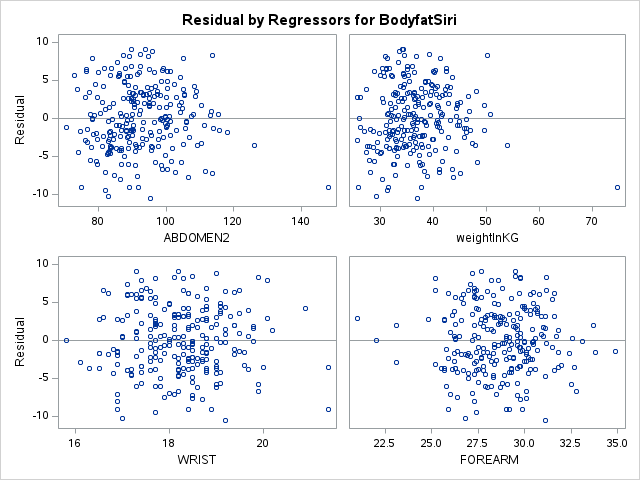
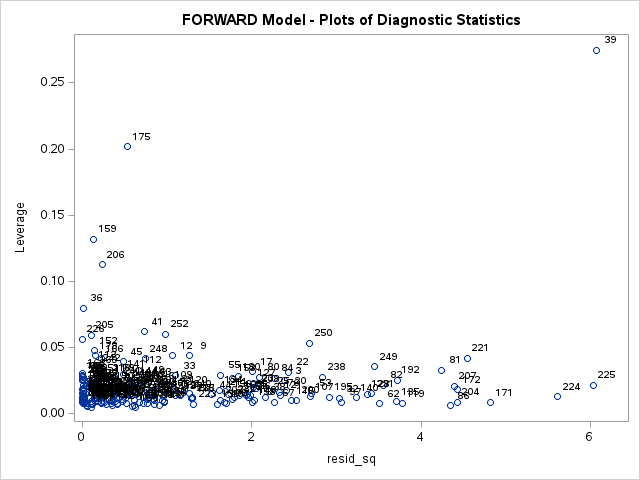

In [75]:
%%SAS sas_sess

proc reg data = my_bodyfat2;
  model BodyFatSiri
                 = Abdomen2 weightInKG Wrist Forearm;
  output out = t student=res cookd = cookd h = lev;
run;

data t; set t;
  resid_sq = res*res;
run;

proc sgplot data = t;
  scatter y = lev x = resid_sq / datalabel = case_no;
run;

As we can see, 39,175,224, 225 have either high leverage or large residuals. We can display the observations that have relatively large values of Cook’s D. A conventional cut-off point is 4/n, where n is the number of observations in the data set. We will use this criterion to select the values to display.

In [76]:
%%SAS sas_sess

proc print data = t;
  where cookd > 4/247;
  var case_no bodyfatSiri Abdomen2 weightInKG Wrist Forearm;
run;

#### Create the residuals output to a data set named influential, subset the data to select only observations that are potentially influential outliers

In [77]:
%%SAS sas_sess

data influential;
/*  Merge datasets from above.*/
    merge Rstud
          Cook 
          Dffits
      Dfbs;
    by observation;

/*  Flag observations that have exceeded at least one cutpoint;*/
    if (ABS(Rstudent)>3) or (Cooksdlabel ne ' ') or Dffitsout then flag=1;
    array dfbetas{*} _dfbetasout: ;
    do i=2 to dim(dfbetas);
        if dfbetas{i} then flag=1;
    end;

/*  Set to missing values of influence statistics for those*/
/*  who have not exceeded cutpoints;*/
    if ABS(Rstudent)<=3 then RStudent=.;
    if Cooksdlabel eq ' ' then CooksD=.;

/*  Subset only observations that have been flagged.*/
    if flag=1;
    drop i flag;
run;

proc print data=influential;
    id observation ID1;
    var Rstudent CooksD Dffitsout _dfbetasout:; 
run;

### Using PROC REG to Assess Collinearity

In [78]:
%%SAS sas_sess

/* VIF between 1 and 5: Moderate multicollinearity (not a major concern). 
   VIF above 5: High multicollinearity (may lead to unreliable coefficient estimates).
*/

ods graphics off;
proc reg data=my_bodyfat2;
   FULLMODL: model bodyfatSiri = Age heightInMeters weightInKG Neck 
        Chest Abdomen2 Hip Thigh Knee Ankle ExtendBiceps Forearm Wrist / vif;
   title 'Collinearity -- Full Model';
run;

ods graphics on;

#### There seems to be high collinearity with WeightInKG, Hip, and Abdomen2. Chest and Thigh are below the cut off but are larger than the others that do not exceed 5.

#### Weight is collinear with some of the other variables, but as you saw before in your model-building process, Weight is a relatively significant predictor in the "best" models. A subject-matter expert should determine to remove or not.

### Finding Outliers, Influence, and Leverage Points
    https://www.youtube.com/watch?v=IiGPEPDyC4I&pp=ygUpc2FzIE91dGxpZXIsIExldmVyYWdlLCBJbmZsdWVudGlhbCBQb2ludHM%3D


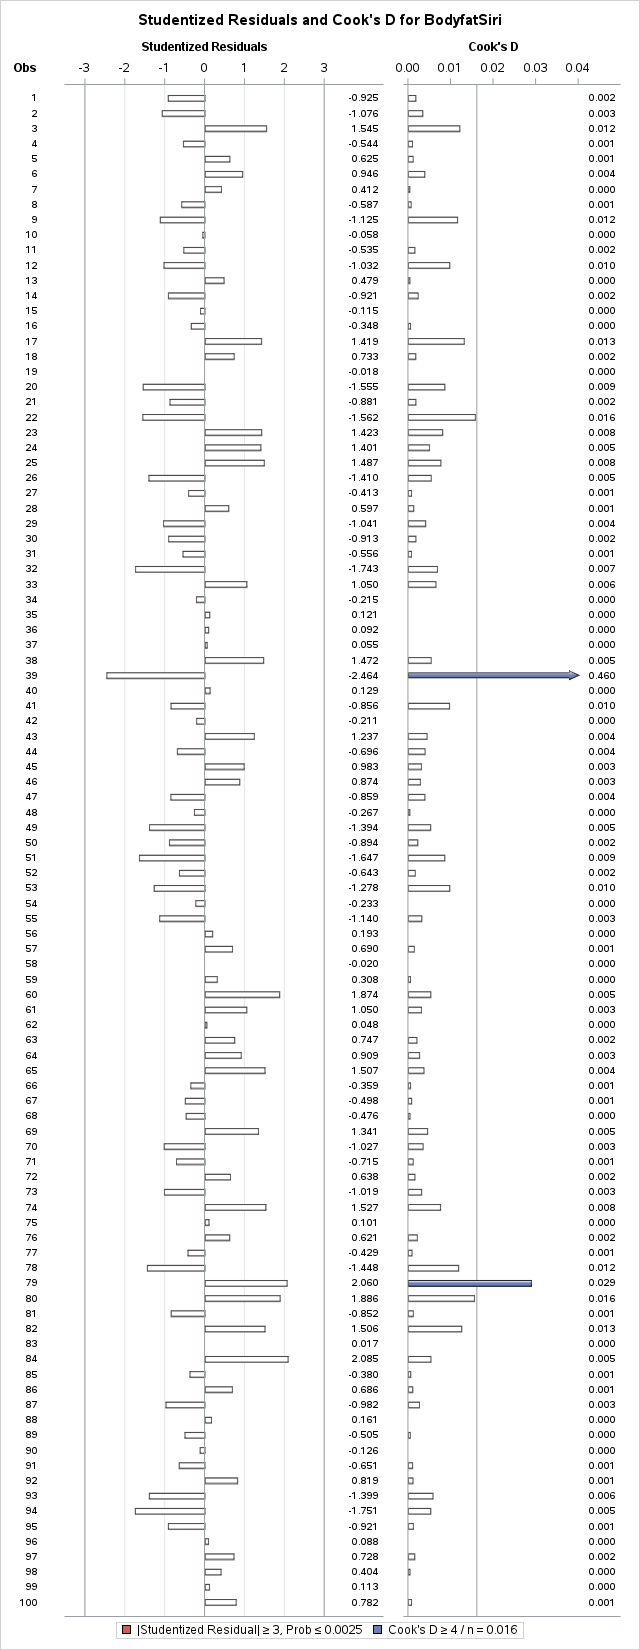
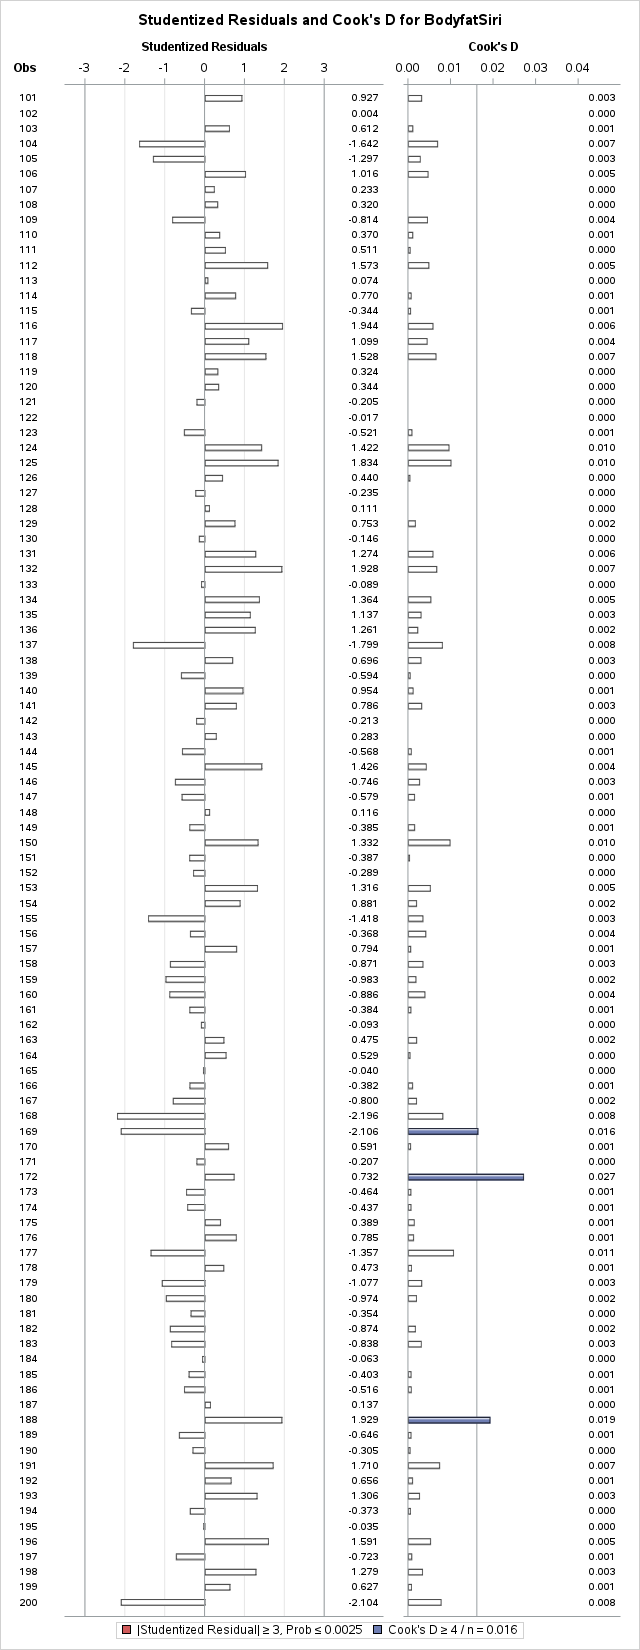
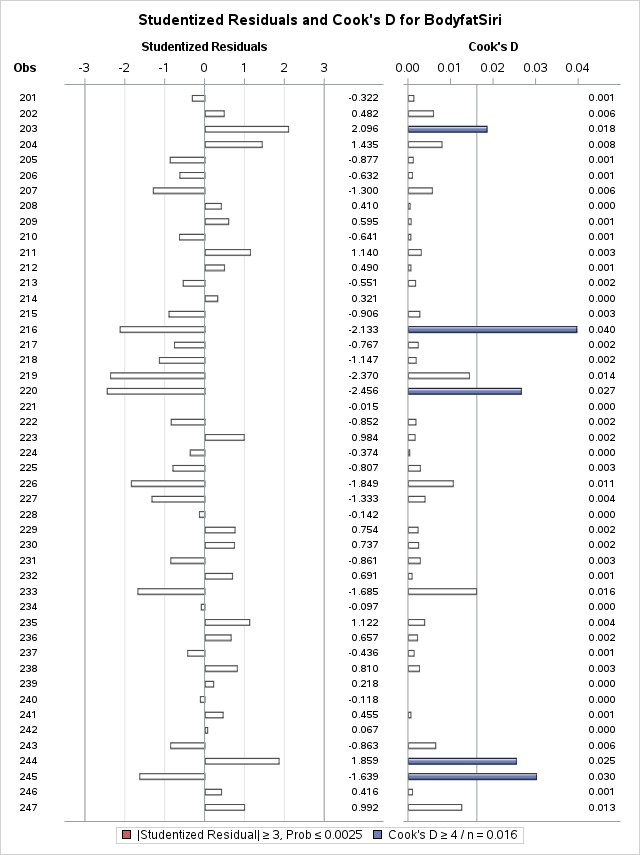
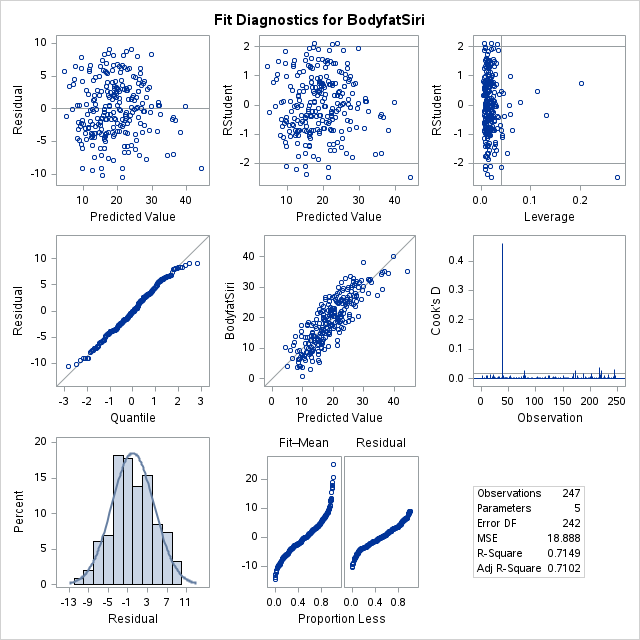
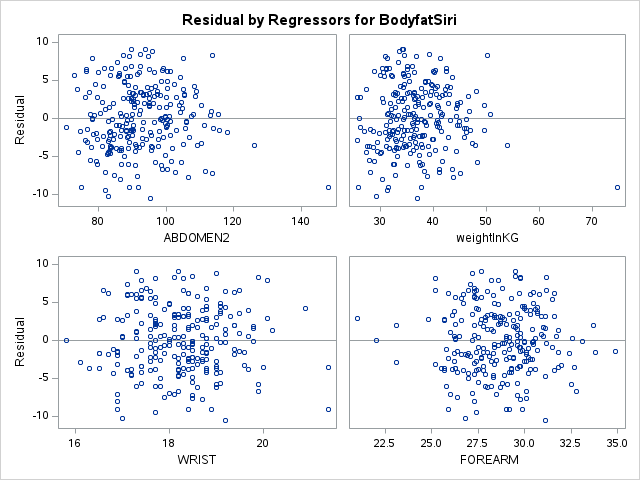

In [79]:
%%SAS sas_sess

PROC REG DATA = my_bodyfat2;
    MODEL bodyfatSiri = Abdomen2 weightInKG Wrist Forearm / r;
    output out=outlier_data student=stud_resids rstudent=stud_del_resids;
RUN;



In [80]:
%%SAS sas_sess

PROC sort DATA=outlier_data out=sorted_data;
    by stud_resids;
    RUN;
    
PROC print DATA=sorted_data;
    var stud_resids stud_del_resids;
RUN;

##### Residual:  
&emsp; The difference between the predicted value (based on the regression equation) and the actual, observed value.

##### Outlier:  
&emsp; In linear regression, an outlier is an observation with large residual.  In other words, it is an observation whose dependent-variable value is unusual given its value on the predictor variables.  An outlier may indicate a sample peculiarity or may indicate a data entry error or other problem.

##### Leverage:  
&emsp; An observation with an extreme value on a predictor variable is a point with high leverage.  Leverage is a measure of how far an independent variable deviates from its mean.  High leverage points can have a great amount of effect on the estimate of regression coefficients.

&emsp; An observation is said to be influential if removing the observation substantially changes the estimate of the regression coefficients.  Influence can be thought of as the product of leverage and outlierness. 

##### Cook’s distance (or Cook’s D): 
&emsp; A measure that combines the information of leverage and residual of the observation. 

    - https://stats.oarc.ucla.edu/sas/dae/robust-regression/

In [ ]:
# Disconnect the session
sas_sess.disconnect()

In [ ]:
# # Reconnect the session
# https://sassoftware.github.io/saspy/advanced-topics.html#disconnecting-from-an-iom-session-and-reconnecting-back-to-it
#sas_sess.reconuri

### Reference
    - https://libguides.library.kent.edu/SAS/exploring
    - https://medium.com/@dada0302000/predicting-body-fat-69bbe9f20d4e
    - https://medium.com/@mygreatlearning/step-by-step-regression-analysis-f7e3e3ebf296
    - https://www.statisticshowto.com/probability-and-statistics/regression-analysis/
    - https://epurdom.github.io/Stat131A/book/multiple-regression.html
    - https://www.scribbr.com/statistics/multiple-linear-regression/
    
    - https://www.statology.org/correlation-in-sas/
    - https://www.statology.org/sas-proc-sgplot-by-group/
    - https://www.statology.org/sas-correlation-matrix/
    - https://www.statology.org/sas-histogram/
    - https://www.stat.purdue.edu/~tqin/system101/method/method_linear_sas.htm
    - https://www.jmp.com/en_us/statistics-knowledge-portal/what-is-multiple-regression/multicollinearity.html
    - https://practicingbi.wordpress.com/2019/10/24/sas-proc-reg-collinearity-diagnostics/
    - https://subscription.packtpub.com/book/data/9781788624565/2/ch02lvl1sec16/dealing-with-multicollinearity
    - https://www.listendata.com/2015/05/ridge-regression-with-sas.html
    - https://media.online.uga.edu/media/PROC%20CORR%20-%20Part%202%20(Partial%20Correlation)/1_et8xgsp4
    - https://stats.oarc.ucla.edu/sas/output/proc-corr/#:~:text=Prob%20%3E%20%7Cr%7C%20under%20H0%3A%20Rho%3D0%20%E2%80%93,correlation%20(Rho)%20is%200.
    - https://incipientanalyst.wordpress.com/2016/03/13/automated-sas-code-for-variable-reduction-variance-inflation-factor-vif/
    - https://jbhender.github.io/Stats506/F17/Projects/G13/Sas.html#introduction|home
    - https://www.usu.edu/math/jrstevens/stat5100/
    - https://quantifyinghealth.com/correlation-collinearity-multicollinearity/
    - https://sassyfridays.ca/table-of-contents/ridge-regression/
    - https://blogs.sas.com/content/iml/2023/03/22/partial-correlation.html
